# Progetto Machine Learning
*di Alessandro Bruno & Alessandra Di Bella*

# Comprensione dei Dati
## Raccolta Dati

Vengono utilizzati due dataset Istat, Cambiamenti e Ampiezza.

In [425]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
# Grafici
import matplotlib.pyplot as plt
import numpy as np
# Base
import pandas as pd
import seaborn as sns
# Modelli per Clustering
from sklearn.cluster import AgglomerativeClustering
# Importazioni per ML
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
# Metriche di valutazione
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Modelli per Regressione
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

# Caricamento iniziale per l'esplorazione
try:
    df_cambiamenti_orig = pd.read_csv(
        'Cambiamenti nelle abitudini di spesa (2018-2021) (IT1,31_739_DF_DCCV_SPEMEFAM_1,1.0).csv', sep=';')
    df_ampiezza_orig = pd.read_csv('Ampiezza della famiglia (IT1,31_739_DF_DCCV_SPEMEFAM_3,1.0).csv', sep=';')
    print("File CSV caricati per l'esplorazione iniziale.")
except FileNotFoundError:
    print("Errore: File non trovati.")
    exit()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
File CSV caricati per l'esplorazione iniziale.


In [426]:
print("\n--- Informazioni sul file 'Cambiamenti' ---")
print(df_cambiamenti_orig.info())


--- Informazioni sul file 'Cambiamenti' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FREQ                        1008 non-null   object 
 1   Frequenza                   1008 non-null   object 
 2   REF_AREA                    1008 non-null   object 
 3   Territorio                  1008 non-null   object 
 4   DATA_TYPE                   1008 non-null   object 
 5   Indicatore                  1008 non-null   object 
 6   COICOP_CATEG                1008 non-null   object 
 7   Gruppo di spesa             1008 non-null   object 
 8   PURCH_BEHAVIOUR             1008 non-null   object 
 9   Abitudine di spesa          1008 non-null   object 
 10  Tempo (TIME_PERIOD)         1008 non-null   int64  
 11  Osservazione                1008 non-null   object 
 12  OBS_STATUS                  135 non-null    f

In [427]:
df_cambiamenti_orig.describe()

,Tempo (TIME_PERIOD),OBS_STATUS
count,1008.000000,135.0
mean,2019.500000,0.0
std,1.118589,0.0
min,2018.000000,0.0
25%,2018.750000,0.0
50%,2019.500000,0.0
75%,2020.250000,0.0
max,2021.000000,0.0


In [428]:
print("\n--- Informazioni sul file 'Ampiezza' ---")
print(df_ampiezza_orig.info())


--- Informazioni sul file 'Ampiezza' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24275 entries, 0 to 24274
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   FREQ                                 24275 non-null  object 
 1   Frequenza                            24275 non-null  object 
 2   REF_AREA                             24275 non-null  object 
 3   Territorio                           24275 non-null  object 
 4   DATA_TYPE                            24275 non-null  object 
 5   Indicatore                           24275 non-null  object 
 6   COICOP                               24275 non-null  object 
 7   Coicop (DESC)                        24275 non-null  object 
 8   NUMBER_HOUSEHOLD_COMP                24275 non-null  object 
 9   Numero di componenti della famiglia  24275 non-null  object 
 10  Tempo (TIME_PERIOD)                  24275 non-null 

In [429]:
df_ampiezza_orig.describe()

,Tempo (TIME_PERIOD),OBS_STATUS
count,24275.000000,1369.0
mean,2016.493306,0.0
std,4.281476,0.0
min,1997.000000,0.0
25%,2015.000000,0.0
50%,2017.000000,0.0
75%,2019.000000,0.0
max,2021.000000,0.0


# Preparazione dei Dati
## Pulizia di `df_cambiamenti`
*Prepariamo la tabella dei cambiamenti per l'analisi e l'unione.*

In [430]:
df_cambiamenti = df_cambiamenti_orig.copy()
df_cambiamenti = df_cambiamenti[df_cambiamenti['Abitudine di spesa'] != 'Tutte le voci'].copy()
# Rinomina esplicita per chiarezza e per evitare conflitti
df_cambiamenti = df_cambiamenti.rename(columns={
    'REF_AREA': 'Macroregione_Cod',
    'Territorio': 'Macroregione_Nome',
    'COICOP_CATEG': 'Gruppo_spesa_cod',
    'Tempo (TIME_PERIOD)': 'Anno',
    'Osservazione': 'PercentualeFamiglie'
})
df_cambiamenti['PercentualeFamiglie'] = pd.to_numeric(df_cambiamenti['PercentualeFamiglie'].replace('..', '0'),
                                                      errors='coerce')
# Selezioniamo solo le colonne che ci servono
df_cambiamenti_clean = df_cambiamenti[
    ['Macroregione_Cod', 'Macroregione_Nome', 'Gruppo_spesa_cod', 'Abitudine di spesa', 'Anno', 'PercentualeFamiglie']]
print("DataFrame 'Cambiamenti' pulito e preparato.")

DataFrame 'Cambiamenti' pulito e preparato.


**Modifiche effettuate:**
1. Copia del DataFrame per non modificare mai i dati originali caricati. In questo modo, se commettiamo un errore, possiamo sempre ripartire dal DataFrame
2. Rimozione di Record con "Tutte le voci" dalla Colonna "Abitudini di spesa" in quanto sono dati ridondanti e derivati dalla somma delle altre cinque opzioni.
3. Rinomina delle Colonne
4. Sostituzione di Record da ".." a 0 dalla Colonna "PercentualeFamiglie" in quanto indicano dati che non raggiungono la soglia minima di affidabilitá statistica, avendo una percentuale troppo bassa.
5. Rimozione di Colonne Ridondanti (Es. "Copicop Categ", "Gruppo di Spesa" teniamo solo "Coicop Categ")

## Pulizia di `df_ampiezza`
*Prepariamo la tabella delle abitudini per l'analisi e l'unione.*

In [431]:
df_ampiezza = df_ampiezza_orig.copy()
df_ampiezza = df_ampiezza.rename(columns={
    'REF_AREA': 'Regione_Cod',
    'Territorio': 'Regione_Nome',
    'Tempo (TIME_PERIOD)': 'Anno',
    'Osservazione': 'SpesaMedia_Micro'
})
df_ampiezza['SpesaMedia_Micro'] = pd.to_numeric(df_ampiezza['SpesaMedia_Micro'], errors='coerce')
df_ampiezza.dropna(subset=['SpesaMedia_Micro'], inplace=True)
print("DataFrame 'Ampiezza' pulito e preparato.")

DataFrame 'Ampiezza' pulito e preparato.


**Modifiche Effettutate:**
1. Copia del DataFrame per non modificare mai i dati originali caricati. In questo modo, se commettiamo un errore, possiamo sempre ripartire dal DataFrame
2. Rinomina delle Colonne
3. Conversione della Colonna "Spesa Media Micro" in tipo Numerico.
4. Rimozione eventuali valori mancanti nella Colonna "SpesaMedia Micro"

## Mappatura
*Creiamo delle colonne "ponte" in `df_ampiezza` per renderlo compatibile con `df_cambiamenti`.*

In [432]:
mappa_categorie = {
    'FOOD': '01', 'BEVER': '02', 'CLOT_FOOTW': '03', 'PCARE_HY': '12',
    'MEX_RPC': '06', 'FUEL_PT': '07', 'TRV_HOL': '09'
}
mappa_inversa_coicop = {v: k for k, v in mappa_categorie.items()}

df_ampiezza['Macroregione_Cod'] = df_ampiezza['Regione_Cod'].str.slice(0, 3)
df_ampiezza['COICOP_agg'] = df_ampiezza['COICOP'].astype(str).str.slice(0, 2)
df_ampiezza['Gruppo_spesa_cod'] = df_ampiezza['COICOP_agg'].map(mappa_inversa_coicop)
df_spesa_mappato = df_ampiezza.dropna(subset=['Gruppo_spesa_cod']).copy()
print("Mappatura eseguita con successo")

Mappatura eseguita con successo


**Modifiche Effettuate:**
1. Mappatura delle categorie associando le 7 macro-categorie di spesa ai codici COICOP aggregati. (solo i primi 2 caratteri)
2. Creazione della Colonna "Gruppo_Spesa_Cod" applicandoci la mappa per tradurre i codici COICOP nella macro-categoria corrispondente.
3. Creazione della Colonna "MacroRegione Cod" estraendo i primi 3 caratteri del Cod. Regionale e ottenendo cosí il codice della Macro Regione.
4. Creazone di un nuovo DataFrame `df_spesa_mappato`, che contiene solo le righe di df_ampiezza per le quali è stato possibile trovare una corrispondenza nelle nostre 7 categorie di interesse.

### Aggregazione

In [433]:
colonne_spesa_da_unire = [
    'Macroregione_Cod', 'Anno', 'Gruppo_spesa_cod', 'Regione_Cod', 'Regione_Nome',
    'COICOP', 'Coicop (DESC)', 'Numero di componenti della famiglia', 'SpesaMedia_Micro'
]

df_finale_dettagliato = pd.merge(
    df_cambiamenti_clean,
    df_spesa_mappato[colonne_spesa_da_unire],
    on=['Macroregione_Cod', 'Anno', 'Gruppo_spesa_cod'],
    how='inner'
)
print(f"Tabella finale dettagliata creata! Numero di righe: {len(df_finale_dettagliato)}")

Tabella finale dettagliata creata! Numero di righe: 30310


**Modifiche Effettuate:**
1. Unione dei due DataFrame abbinando i Record che hanno gli stessi valori nelle Colonne "MacroRegione Cod", "Anno", "Gruppo Spesa Cod".
2. Utilizziamo `inner join` per garantire che nel risultato finale siano presenti solo le combinazioni Anno/Territorio/Categoria per cui esistono dati validi in entrambi i file originali.

## Integrazione Dati

In [434]:
df_finale_dettagliato['SpesaMedia_Macro'] = df_finale_dettagliato.groupby(
    ['Macroregione_Cod', 'Anno', 'Gruppo_spesa_cod']
)['SpesaMedia_Micro'].transform('mean').round(2)
print("Aggiunta la colonna 'SpesaMedia_Macro' alla tabella finale.")

Aggiunta la colonna 'SpesaMedia_Macro' alla tabella finale.


**Modifiche Effettuate:**
1. Creazione di una nuova Colonna "Spesa Media Macro" che, per ogni riga, contiene la spesa media calcolata a livello di macro-regione.

## Pulizia Finale

In [435]:
colonne_originali_da_tenere = [
    'Macroregione_Nome',
    'Regione_Nome',
    'Anno',
    'Gruppo_spesa_cod',
    'Coicop (DESC)',
    'Abitudine di spesa',
    'PercentualeFamiglie',
    'Numero di componenti della famiglia',
    'SpesaMedia_Macro',
    'SpesaMedia_Micro'
]

column_renames = {
    'Macroregione_Nome': 'Macro Regione',
    'Regione_Nome': 'Regione',
    'Gruppo_spesa_cod': 'Macro Gruppo Spesa',
    'SpesaMedia_Micro': 'Micro Spesa Media',
    'Abitudine di spesa': 'Abitudine Spesa',
    'PercentualeFamiglie': 'Percentuale Famiglie',
    'Numero di componenti della famiglia': 'Numero Componenti Famiglia',
    'SpesaMedia_Macro': 'Macro Spesa Media',
    'Coicop (DESC)': 'Micro Gruppo Spesa',
}

df_finale = df_finale_dettagliato[colonne_originali_da_tenere].rename(columns=column_renames)
df_finale.info()
print("Tabella finale pronta.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30310 entries, 0 to 30309
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Macro Regione               30310 non-null  object 
 1   Regione                     30310 non-null  object 
 2   Anno                        30310 non-null  int64  
 3   Macro Gruppo Spesa          30310 non-null  object 
 4   Micro Gruppo Spesa          30310 non-null  object 
 5   Abitudine Spesa             30310 non-null  object 
 6   Percentuale Famiglie        30310 non-null  float64
 7   Numero Componenti Famiglia  30310 non-null  object 
 8   Macro Spesa Media           30310 non-null  float64
 9   Micro Spesa Media           30310 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 2.3+ MB
Tabella finale pronta.


**Modifiche Effettuate:**
1. Selezioniamo solo le Colonne desiderate per la tabella finale.

In [436]:
df_finale.head()

,Macro Regione,Regione,Anno,Macro Gruppo Spesa,Micro Gruppo Spesa,Abitudine Spesa,Percentuale Famiglie,Numero Componenti Famiglia,Macro Spesa Media,Micro Spesa Media
0,Italia,Italia,2018,FOOD,-- prodotti alimentari e bevande analcoliche,Un anno fa li compravo e continuo a comprarli ...,65.6,1,113.28,285.38
1,Italia,Italia,2018,FOOD,-- prodotti alimentari e bevande analcoliche,Un anno fa li compravo e continuo a comprarli ...,65.6,2,113.28,473.24
2,Italia,Italia,2018,FOOD,-- prodotti alimentari e bevande analcoliche,Un anno fa li compravo e continuo a comprarli ...,65.6,3,113.28,553.82
3,Italia,Italia,2018,FOOD,-- prodotti alimentari e bevande analcoliche,Un anno fa li compravo e continuo a comprarli ...,65.6,4,113.28,632.19
4,Italia,Italia,2018,FOOD,-- prodotti alimentari e bevande analcoliche,Un anno fa li compravo e continuo a comprarli ...,65.6,5 e più,113.28,698.70


# Fase 1
## Analisi Esplorativa dei Dati
*Analizziamo i dati per capire le tendenze e le correlazioni.*

In [437]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

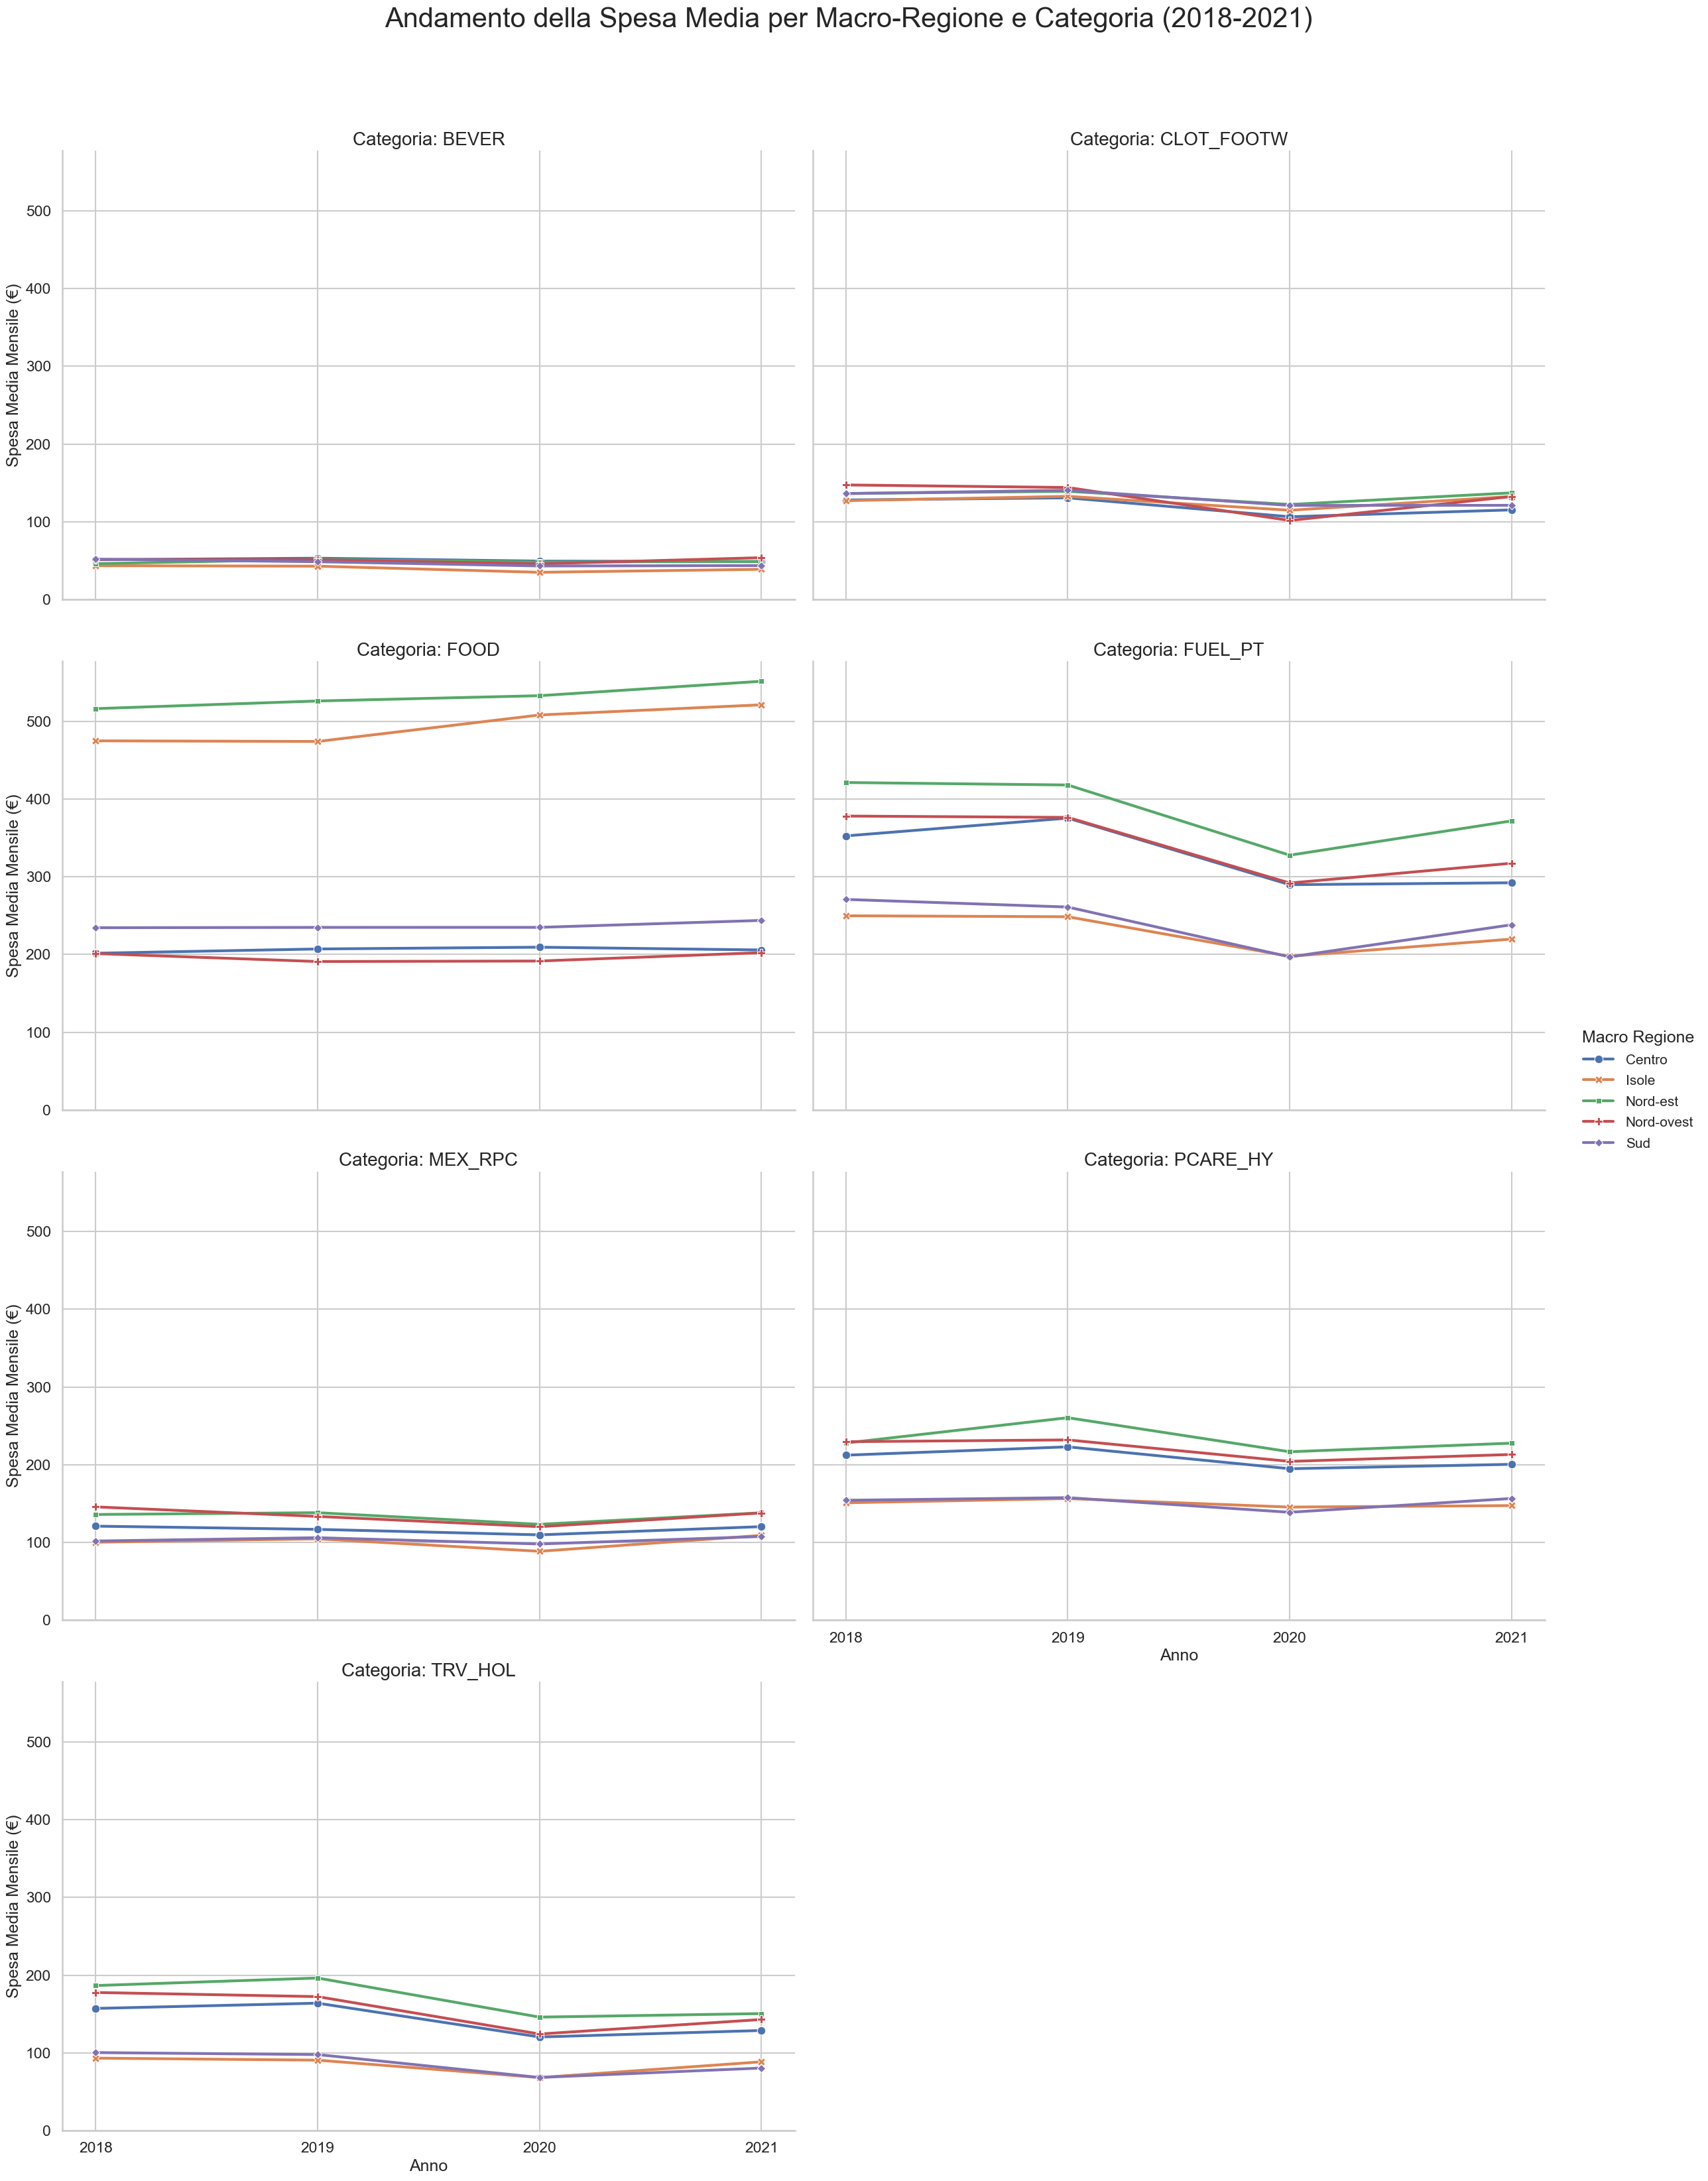

In [438]:
# Preparazione dei dati per il grafico
df_confronto_macro = df_finale[df_finale['Macro Regione'] != 'Italia'].copy()
df_plot = df_confronto_macro.groupby(
    ['Macro Regione', 'Anno', 'Macro Gruppo Spesa']
)['Macro Spesa Media'].mean().reset_index()

# 1. Creazione del Grafico
sns.set_context("talk")

# 2. Creazione della griglia dei grafici
g = sns.FacetGrid(
    df_plot,
    col='Macro Gruppo Spesa',
    col_wrap=2,
    height=8,
    aspect=1.5,
)

# 3. Mappiamo i dati sulla griglia
g.map_dataframe(
    sns.lineplot,
    x='Anno',
    y='Macro Spesa Media',
    hue='Macro Regione',
    style='Macro Regione',
    markers=True,
    dashes=False,
    linewidth=3
)

# 4. Impostiamo i valori degli assi e le etichette
g.set(ylim=(0, None), xticks=[2018, 2019, 2020, 2021])
g.fig.canvas.draw()

# 5. Miglioriamo l'estetica del grafico
g.set_axis_labels("Anno", "Spesa Media Mensile (€)")
g.set_titles("Categoria: {col_name}", size=20)
g.fig.suptitle('Andamento della Spesa Media per Macro-Regione e Categoria (2018-2021)', fontsize=30, y=1.03)

# 6. Aggiungiamo la legenda
g.add_legend(title='Macro Regione')
if g._legend is not None:
    plt.setp(g._legend.get_title(), fontsize=18)
    for text in g._legend.get_texts():
        text.set_fontsize(15)

g.tight_layout()

plt.show()

**Obiettivo:**

Tracciare l'evoluzione della spesa media mensile per diverse categorie di beni nelle principali macro-regioni italiane dal 2018 al 2021.

### **Interpretazione per Categoria di Spesa**

**1. BEVER (Bevande):**

Le linee sono quasi piatte e molto vicine tra loro, non si notano cali significativi nel 2020. Da questo deduciamo che le bevande sono una categoria di spesa con un impatto molto stabile sulla spesa familiare, poco influenzata dalle dinamiche macroeconomiche o regionali.

**2. CLOT_FOOTW (Abbigliamento e Calzature):**

Tutte le macro-regioni mostrano un **calo visibile nel 2020**, con un leggero recupero nel 2021, ma senza tornare ai livelli pre-pandemia del 2019. Questa categoria è stata **penalizzata dalla pandemia**. La riduzione degli eventi sociali, del lavoro in presenza e l'incertezza economica hanno portato a minori acquisti.

**3. FOOD (Cibo):**

Le linee sono generalmente stabili o in leggera crescita nel 2020-2021, non si osserva il calo drastico visto per l'abbigliamento. Il cibo è un **bene essenziale e resiliente**, per questo la sua spesa è stabile e non ha subito riduzioni significative con la pandemia.

**4. FUEL_PT (Carburanti per Mezzi Privati)**

Si osserva un **netto calo nel 2020** per tutte le regioni (dovuto ai lockdown e alla riduzione della mobilità), seguito da una ripresa nel 2021. La spesa per carburanti è stata **direttamente influenzata dalle restrizioni alla mobilità**. La ripresa è legata al ritorno delle attività; il mancato recupero totale potrebbe essere dovuto allo smart working introdotto maggiormente dopo il covid.

**5. MEX_RPC (Visite Mediche e Accertamenti Preventivi):**

Le linee sono abbastanza stabili, con un leggero calo nel 2020 per alcune regioni e un recupero nel 2021. La spesa medica privata è relativamente **stabile** in quanto anche in tempi di crisi, le persone tendono a non eliminare queste spese.

**6. PCARE_HY (Cura e Igiene Personale):**

Anche questa è una categoria di spesa con un'alta componente di necessità, e quindi relativamente **stabile** e meno influenzata dalle fluttuazioni economiche.

**7. TRV_HOL (Viaggi e Vacanze):**

Tutte le macro-regioni mostrano un **calo nel 2020**, seguito da un leggero rialzo nel 2021, ma i livelli di spesa rimangono **al di sotto** di quelli pre-pandemici del 2018-2019. Le restrizioni ai viaggi e l'incertezza hanno ridotto di molto i consumi in questo settore, e il recupero è lento.

### Conclusioni

- La pandemia del 2020 ha colpito duramente settori come Abbigliamento, Carburanti e soprattutto Viaggi, mentre ha avuto un impatto minimo sui beni essenziali come Cibo e Cura della Persona.
- Indipendentemente dalla categoria, le regioni del Nord (Nord-est, Nord-ovest) mostrano quasi sempre una spesa media mensile significativamente più alta rispetto al Centro, Sud e Isole. Questo evidenzia le profonde differenze socio-economiche strutturali in Italia.

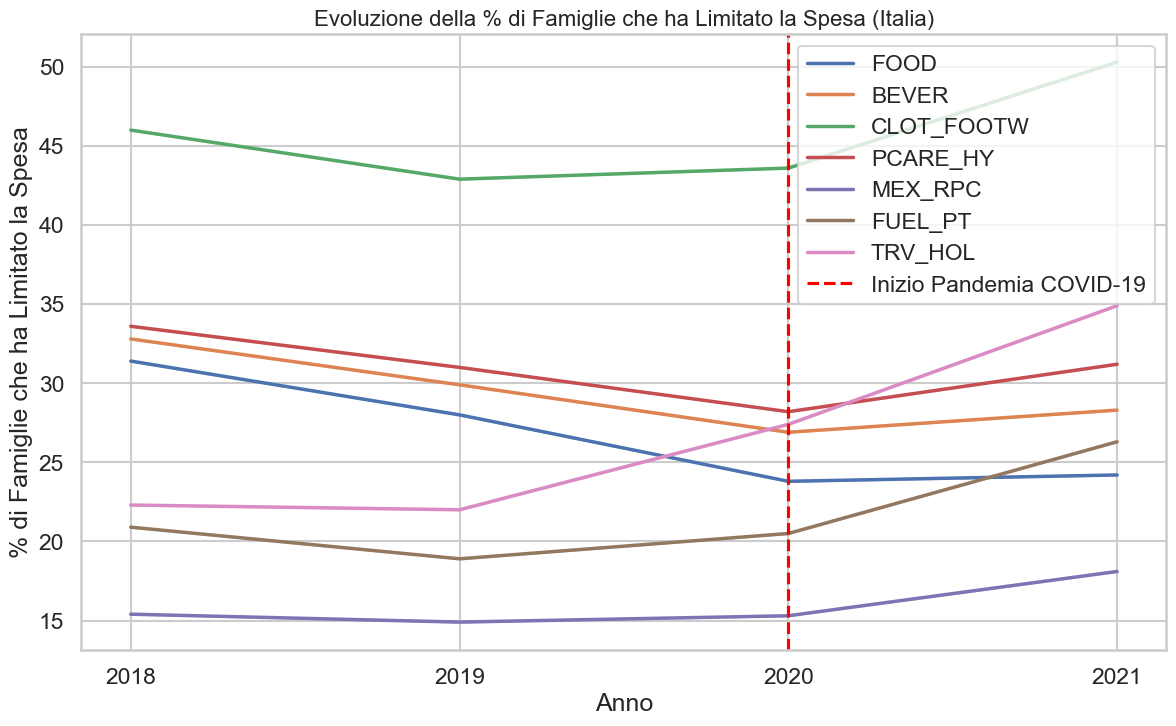

In [439]:
df_limitata = df_finale[
    (df_finale['Abitudine Spesa'] == 'Un anno fa li compravo e ho limitato la spesa in quantità e/o qualità') &
    (df_finale['Macro Regione'] == 'Italia')
    ]
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_limitata, x='Anno', y='Percentuale Famiglie', hue='Macro Gruppo Spesa', lw=2.5)
plt.title('Evoluzione della % di Famiglie che ha Limitato la Spesa (Italia)', fontsize=16)
plt.xlabel('Anno')
plt.ylabel('% di Famiglie che ha Limitato la Spesa')
plt.axvline(2020, color='red', linestyle='--', label='Inizio Pandemia COVID-19')
plt.legend()
plt.xticks([2018, 2019, 2020, 2021])
plt.show()

**Obiettivo:**

Il grafico traccia la percentuale di famiglie italiane che hanno dichiarato di aver limitato la spesa per diverse categorie di beni tra il 2018 e il 2021. La linea verticale rossa nel 2020 indica l'inizio della pandemia di COVID-19.

### Interpretazione

**1. CLOT_FOOTW (Abbigliamento e Calzature):**

Questa linea è la più alta tra le categorie e mostra un **alto aumento** della percentuale di famiglie che hanno limitato la spesa, partendo da circa il 45% nel 2018-2020, per poi **salire drasticamente nel 2021, superando il 50%**. Questa é la categoria che ha subito il più grande aumento di limitazione della spesa poiché non é considerato un bene essenziale.

**2. TRV_HOL (Viaggi e Vacanze):**

Mostra un **aumento netto della limitazione** che inizia già nel 2019, ma che **accelera nel 2020-2021**. Le famiglie che limitano la spesa per i viaggi passano da circa il 22% nel 2019 a quasi il 35% nel 2021 (+13%).

**3. FUEL_PT (Carburanti per Mezzi Privati):**

Questa categoria viene fortemente influenzata dalle restrizioni alla mobilitá, dal diffondersi dello smartworking e dagli aumenti dei costi delle autovetture e dei Carburanti portando ad un aumento della percentuale di limitazione dal 2019 partendo da un 22% circa ad arrivare a un 27% circa

**4. FOOD (Cibo):**

Essendo il Cibo un bene essenziale, la pandemia non ha avuto un grande impatto.

**5. BEVER (Bevande - Linea Arancione):**

Simile al cibo essendo acquistati insieme, ed essendo anch'esso un bene essenziale.

**6. PCARE_HY (Cura e Igiene Personale):**

I prodotti per la cura personale sono percepiti come essenziali ed hanno un andamento simile a quello del Cibo e delle Bevande.

**7. MEX_RPC (Visite Mediche e Accertamenti Preventivi):**

Dal 2020 é aumentata la percentuale di famiglie che limitano queste spese probabilmente a causa dell'impossibilità di fare visite essendoci il Lockdown.

**Conclusioni**

La pandemia ha costretto le famiglie a razionalizzare le spese, costringendole a scegliere quali beni siano Essenziali e quali non lo siano.

## Mappa del Costo della Vita Regionale (Spesa Pro Capite)
Quali sono le regioni italiane dove il costo della vita, misurato come Spasa media pro capite per i bent essential, è più alto?

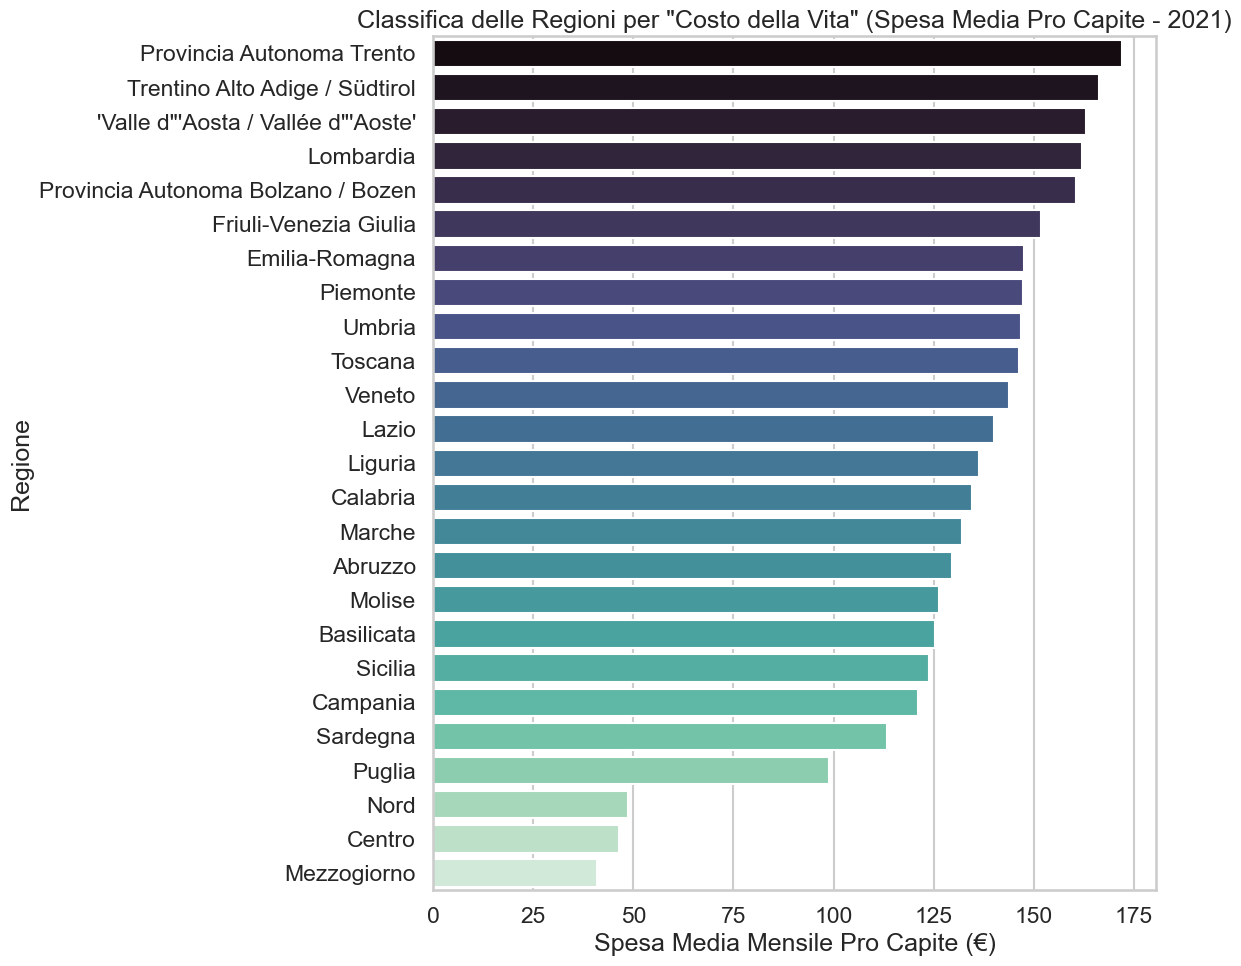

In [440]:
df_finale['Numero Componenti Famiglia'] = pd.to_numeric(df_finale['Numero Componenti Famiglia'], errors='coerce')
df_finale['Spesa Pro Capite'] = (df_finale['Micro Spesa Media'] / df_finale['Numero Componenti Famiglia']).round(2)

# Filtriamo per il 2021 e categorie essenziali
df_costo_vita = df_finale[
    (df_finale['Anno'] == 2021) &
    (df_finale['Macro Gruppo Spesa'].isin(['FOOD', 'FUEL_PT', 'PCARE_HY'])) &
    (df_finale['Regione'] != 'Italia')
    ]

# Aggreghiamo per regione
classifica_regioni = df_costo_vita.groupby('Regione')['Spesa Pro Capite'].mean().sort_values(ascending=False)

# Creazione del grafico
plt.figure(figsize=(12, 10))
barplot = sns.barplot(x=classifica_regioni.values, y=classifica_regioni.index, palette="mako",
                      hue=classifica_regioni.index, legend=False)
plt.title('Classifica delle Regioni per "Costo della Vita" (Spesa Media Pro Capite - 2021)', fontsize=18)
plt.xlabel('Spesa Media Mensile Pro Capite (€)')
plt.ylabel('Regione')
plt.tight_layout()
plt.show()

## 1. Descrizione Grafico
- Questo grafico classifica le regioni e le macro-aree italiane in base alla loro spesa media mensile pro capite nel 2021.
- La spesa è stata calcolata come media delle categorie considerate "essenziali" (FOOD, FUEL_PT, PCARE_HY). 
- Le barre sono ordinate in modo decrescente, dalla spesa più alta alla più bassa.
- Sull'asse y troviamo il nome della Regione o della Macro-Area
- Sull'asse x troviamo la misura della spesa media mensile pro capite in euro

## 2. Cosa capiamo da questi dati

- La top 5 è interamente occupata da province autonome e regioni dell'arco alpino: Provincia Autonoma di Trento è in testa con una spesa pro capite di circa 170€, seguita da Trentino Alto Adige, Valle d'Aosta, Lombardia e Provincia Autonoma di Bolzano. Queste aree mostrano un costo della vita più elevato rispetto al resto d'Italia.
- Divisione Nord-Centro-Sud: quasi tutte le regioni del Nord e alcune del Centro (come Umbria e Toscana) si posizionano nella metà superiore della classifica, le altre regioni si posizionano sotto. Il Mezzogiorno si posiziona all'ultimo posto con la spesa pro capite più bassa (sotto i 50€), confermando che il costo della vita percepito in quest'area è, in media, molto inferiore rispetto al Nord.

## 3. Interpretazione e Implicazioni di Business/Socio-economiche
- Le regioni con i redditi pro capite più alti (Lombardia, Trentino-Alto Adige) sono anche quelle dove la spesa per beni e servizi essenziali è maggiore. 
- Per un'azienda che vende prodotti di largo consumo, questa analisi è molto importante, suggerendo un rialzo dei prezzi dei propri prodotti nelle zone dove il potere d'acquisto e la spesa media sono maggiori, puntando sulla qualità dei prodotti, e inserire offerte speciali e prodotti scontati per le regioni in fondo alla classifica, puntando di piú sulla convenienza. La pubblicità degli stessi prodotti potrebbe quindi puntare di piu sulla qualità dei prodotti al nord, e sul risparmio e sul rapporto qualità-prezzo al sud.

## Impatto sui Beni Non Essenziali
Come ha reagito la spesa per beni non essenziali (Abbigliamento, Viaggi) rispetto a quella per beni essenziali (Cibo) durante il picco della crisi (2019 vs 2020)?

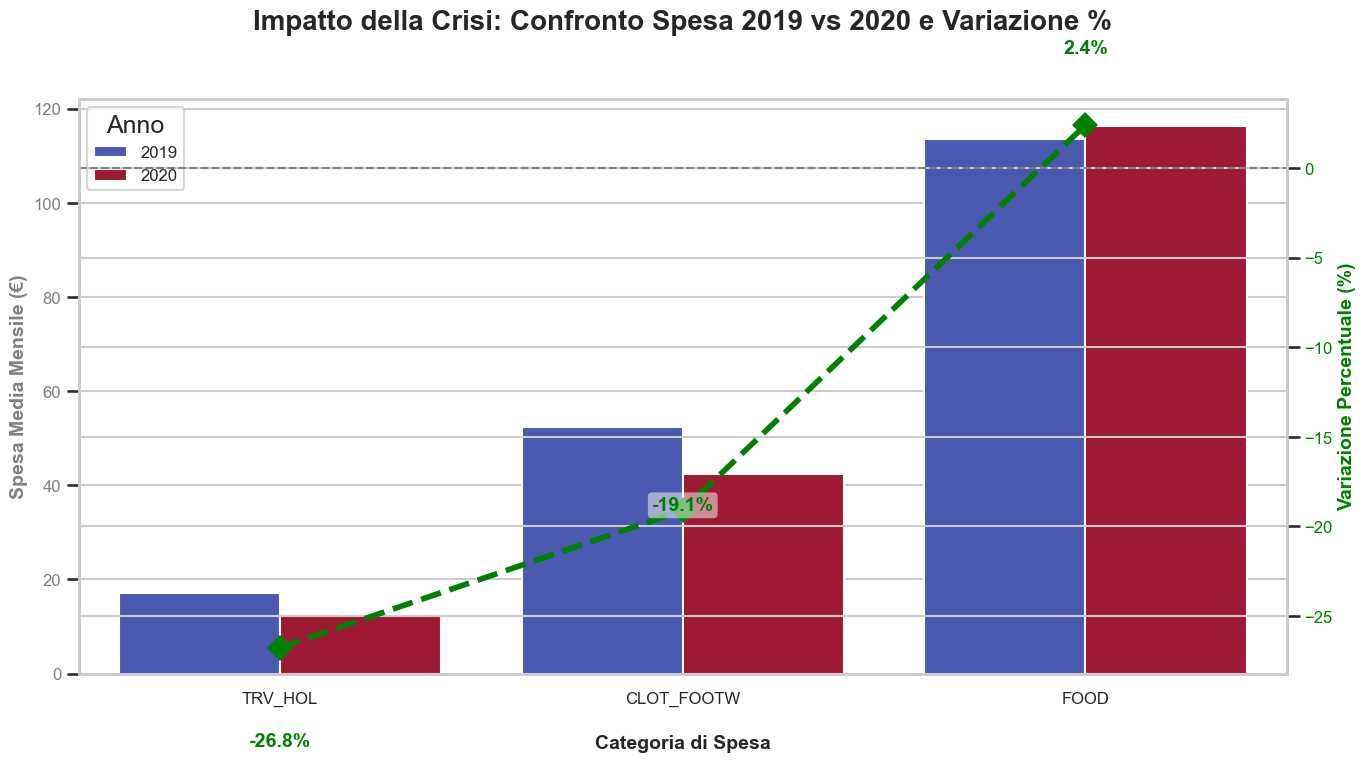

In [441]:
df_crisi = df_finale[
    (df_finale['Anno'].isin([2019, 2020])) &
    (df_finale['Macro Regione'] == 'Italia') &
    (df_finale['Macro Gruppo Spesa'].isin(['FOOD', 'CLOT_FOOTW', 'TRV_HOL']))
    ]

df_pivot = df_crisi.pivot_table(
    index='Macro Gruppo Spesa',
    columns='Anno',
    values='Macro Spesa Media'
).reset_index()

df_pivot['Variazione %'] = ((df_pivot[2020] - df_pivot[2019]) / df_pivot[2019]) * 100
df_pivot = df_pivot.sort_values('Variazione %', ascending=True)
ordine_categorie = df_pivot['Macro Gruppo Spesa'].tolist()

df_plot_crisi = df_crisi.copy()
df_plot_crisi['Macro Gruppo Spesa'] = pd.Categorical(
    df_plot_crisi['Macro Gruppo Spesa'],
    categories=ordine_categorie,
    ordered=True
)

fig, ax1 = plt.subplots(figsize=(14, 8))

sns.barplot(data=df_plot_crisi, x='Macro Gruppo Spesa', y='Macro Spesa Media', hue='Anno', palette='coolwarm', ax=ax1)

ax1.set_title(
    'Impatto della Crisi: Confronto Spesa 2019 vs 2020 e Variazione %',
    fontsize=20,
    weight='bold',
    pad=50
)
ax1.set_xlabel(
    'Categoria di Spesa',
    fontsize=14,
    weight='bold',
    labelpad=20
)
ax1.set_ylabel('Spesa Media Mensile (€)', fontsize=14, weight='bold', color='gray')
ax1.tick_params(axis='y', labelcolor='gray', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(title='Anno', loc='upper left', fontsize=12)

ax2 = ax1.twinx()

sns.pointplot(
    data=df_pivot,
    x='Macro Gruppo Spesa',
    y='Variazione %',
    order=ordine_categorie,
    color='green',
    markers='D',
    markersize=10,
    linestyle='--',
    ax=ax2
)

ax2.set_ylabel('Variazione Percentuale (%)', fontsize=14, weight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)
ax2.axhline(0, color='grey', linestyle='--', lw=1.5)

for i, categoria in enumerate(ordine_categorie):
    riga_dati = df_pivot[df_pivot['Macro Gruppo Spesa'] == categoria]
    variazione = riga_dati['Variazione %'].iloc[0]

    vertical_offset = 4 if variazione > 0 else -5.5

    # *** Aggiungiamo una condizione specifica per la categoria 'CLOT_FOOTW' ***
    if categoria == 'CLOT_FOOTW':
        vertical_offset = 0

    ax2.text(
        x=i,
        y=variazione + vertical_offset,
        s=f"{variazione:.1f}%",
        color='green',
        ha='center',
        size=14,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2')
    )

fig.tight_layout()
plt.show()

### Interpretazione

**1. FOOD (Cibo):**

Nonostante la crisi economica, la spesa per il cibo non solo non è diminuita, ma è leggermente aumentata. Questo fenomeno è giustificato dai lockdown: con ristoranti, bar e mense chiusi o limitati, le famiglie hanno spostato i loro consumi alimentari quasi interamente sull'acquisto di prodotti da consumare a casa, cucinando di più.

**2. CLOT_FOOTW (Abbigliamento e Calzature):**

Questa categoria é stata quella piú limitata. Le cause sono molteplici: smart working, assenza di eventi sociali, chiusura dei negozi e incertezza economica hanno spinto le famiglie a posticipare o annullare acquisti non strettamente necessari.

**3. TRV_HOL (Viaggi e Vacanze):**

Questa categoria ha subito anch'essa un grande imaptto dovuto alla crisi e alle restrizioni alla mobilità.

## Distribuzione delle Abitudini di spesa per categoria

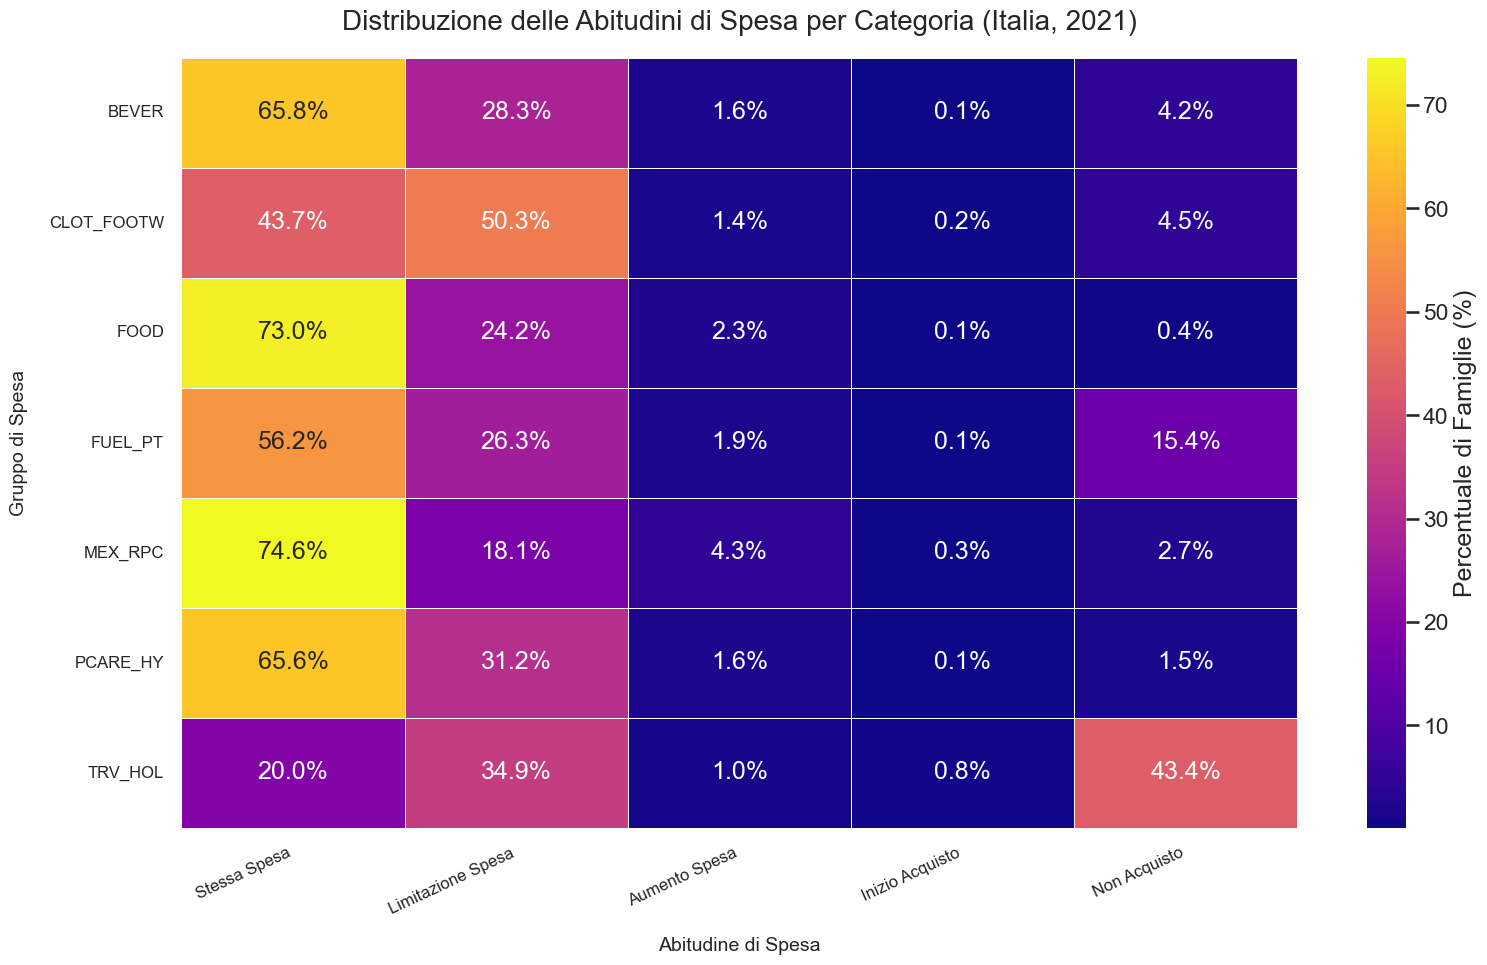

In [442]:
df_heatmap_data = df_finale[
    (df_finale['Anno'] == 2021) &
    (df_finale['Macro Regione'] == 'Italia')
    ].copy()

if df_heatmap_data.empty:
    print("Errore: Nessun dato trovato per 'Italia' nell'anno 2021 nel df_finale.")
else:
    heatmap_pivot = df_heatmap_data.pivot_table(
        index='Macro Gruppo Spesa',
        columns='Abitudine Spesa',
        values='Percentuale Famiglie',
        aggfunc='mean'
    )

    col_rename_map = {
        'Un anno fa li compravo e continuo a comprarli senza modifiche': 'Stessa Spesa',
        'Un anno fa li compravo e ho limitato la spesa in quantità e/o qualità': 'Limitazione Spesa',
        'Un anno fa li compravo e ho aumentato la spesa in quantità e/o qualità': 'Aumento Spesa',
        'Un anno fa non li compravo e ho iniziato a comprarli': 'Inizio Acquisto',
        'Un anno fa non li compravo e continuo a non comprarli': 'Non Acquisto'
    }
    heatmap_pivot.rename(columns=col_rename_map, inplace=True)

    col_order = ['Stessa Spesa', 'Limitazione Spesa', 'Aumento Spesa', 'Inizio Acquisto', 'Non Acquisto']
    heatmap_pivot = heatmap_pivot.reindex(columns=col_order)

    plt.figure(figsize=(18, 10))


    def format_percent(value):
        return f"{value:.1f}%"


    annot_data = heatmap_pivot.map(format_percent)

    heatmap = sns.heatmap(
        heatmap_pivot,
        annot=annot_data,
        fmt="",
        cmap='plasma',
        linewidths=.5,
        cbar_kws={'label': 'Percentuale di Famiglie (%)'}
    )

    plt.title('Distribuzione delle Abitudini di Spesa per Categoria (Italia, 2021)', fontsize=20, pad=20)
    plt.xlabel('Abitudine di Spesa', fontsize=14, labelpad=15)
    plt.ylabel('Gruppo di Spesa', fontsize=14, labelpad=15)
    plt.xticks(rotation=25, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

### Analisi e Interpretazione

La mappa di calore utilizza i colori chiari (giallo) per indicare percentuali alte di famiglie che ha adottato una certa abitudine di spesa per una specifica categoria, e usa i colori scuri (blu) per indicare percentuali basse.

#### 1. I beni essenziali

La colonna "Stessa Spesa" (famiglie che non hanno modificato le loro abitudini) è quella con i valori mediamente più alti. I picchi si osservano per:
*   MEX_RPC (Visite Mediche e Salute): 74.6%
*   FOOD (Cibo): 73.0%
*   PCARE_HY (Cura e Igiene Personale): 65.6%
*   BEVER (Bevande): 65.8%

Questo ci conferma che salute e alimentazione sono considerati beni primari a cui le persone non rinunciano, anche in periodi di crisi.

#### 2. I beni Non Essenziali

La colonna "Limitazione Spesa" mostra valori più alti per le categorie riguardanti beni non essenziali, come:
*   CLOT_FOOTW (Abbigliamento e Calzature): 50.3%
*   TRV_HOL (Viaggi e Vacanze): 34.9%

Questo ci fa capire che più della metà delle famiglie ha tagliato la spesa per l'abbigliamento, rendendo questa categoria la più sacrificata tra tutte seguita dai viaggi. Capiamo quindi che, di fronte a incertezza economica o a restrizioni (come quelle post-pandemiche), le prime spese a essere ridotte sono quelle legate allo svago, all'apparenza e al tempo libero in generale. È interessante notare che anche per PCARE_HY (Cura della Persona), quasi un terzo delle famiglie (31.2%) ha limitato la spesa, suggerendo che anche alcuni prodotti di bellezza o servizi non essenziali in questa categoria vengono tagliati.

#### 3. Aumento della Spesa

La colonna "Aumento Spesa" presenta valori molto bassi in tutte le categorie, generalmente tra l'1% e il 2.3%. L'unico valore leggermente superiore è per MEX_RPC (Salute) con il 4.3%.

Questo ci fa capire che nel 2021 non c'è stata una spinta generalizzata ad aumentare i consumi. L'eccezione relativa alla salute potrebbe essere spiegata da una maggiore attenzione post-pandemica verso la prevenzione o dalla necessità di recuperare visite e controlli rimandati nel 2020. In ogni caso, l'aumento della spesa non è il fattore principale.

#### 4. I Nuovi Acquisti e il Non Acquisto

Le ultime due colonne sono molto importanti:
*   Per l'"Inizio Acquisto" i valori sono vicini allo zero (0.1-0.8%) per quasi tutte le categorie.
*   Per il *"Non Acquisto"*invece vediamo che:
    *   TRV_HOL (Viaggi): 43.4% delle famiglie dichiara di non aver speso nulla in questa categoria (né l'anno prima né nel 2021).
    *   FUEL_PT (Carburanti): 15.4% delle famiglie non spende per carburanti.

Vediamo quindi che quasi la metà delle famiglie italiane non spende per i viaggi, dato che porta con sè sia effetti economici di lungo periodo sia gli ultimi residui della pandemia.
I dati sui Carburanti rivelano inoltre che una fetta non trascurabile della popolazione (circa 1 su 6) non possiede o non utilizza un mezzo privato, usando probabilmente i mezzi pubblici o vivendo in contesti in cui non è necessario avere un proprio mezzo.

### Conclusione

*   Salute (MEX_RPC) e Cibo (FOOD): Sono le meno colpite dalla crisi.
*   Abbigliamento e Calzature (CLOT_FOOTW): La categoria più sacrificata. È la prima a subire cali quando la situazione economica peggiora.
*   Viaggi e Vacanze (TRV_HOL): E' una categoria "di lusso" o "esclusiva", pertanto non solo è la seconda più tagliata da chi già ne usufruiva, ma è anche inaccessibile per una larghissima fetta della popolazione (43.4%).
*   Carburanti (FUEL_PT): Un bene necessario per chi possiede un'auto, ma con una significativa quota di famiglie che ne è esclusa. Anche qui, un quarto delle famiglie (26.3%) ha cercato di limitarne l'uso, probabilmente a causa dell'aumento dei prezzi.

## Correlazione Spesa vs Tendenza al Taglio - Confronto pre e post Pandemia

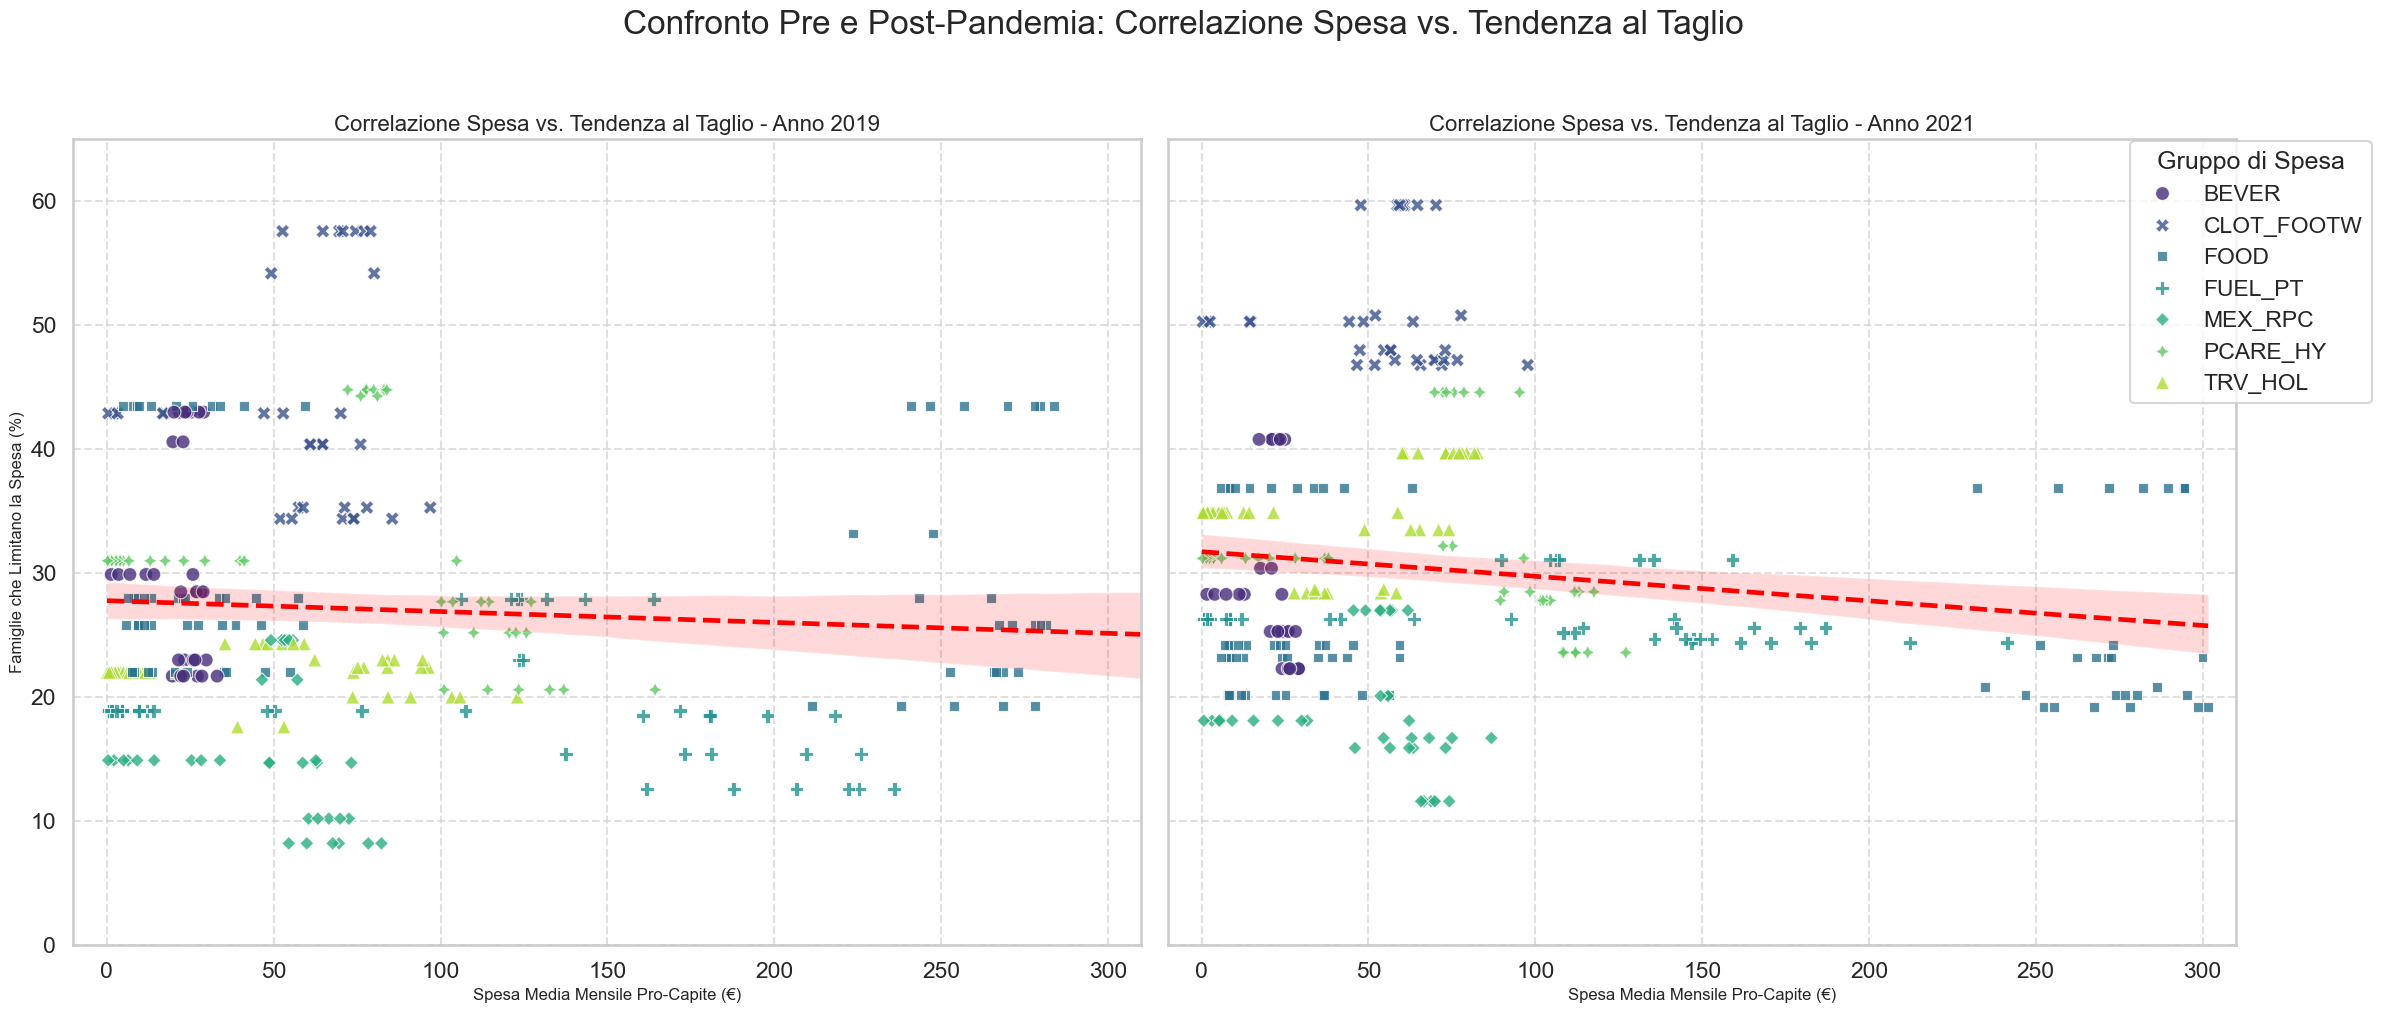

In [443]:

def plot_correlation_scatter(df, anno, ax):
    df_anno_data = df[
        (df['Anno'] == anno) &
        (df['Abitudine Spesa'] == "Un anno fa li compravo e ho limitato la spesa in quantità e/o qualità")
        ].copy()

    if df_anno_data.empty:
        ax.text(0.5, 0.5, f"Nessun dato disponibile per l'anno {anno}", ha='center', va='center')
        ax.set_title(f'Analisi per l\'Anno {anno}', fontsize=16)
        return

    df_plot = df_anno_data.groupby(['Regione', 'Macro Gruppo Spesa', 'Micro Gruppo Spesa']).agg(
        Spesa_Pro_Capite=('Micro Spesa Media', lambda x: x.mean() / 2),
        Percentuale_Limitazione=('Percentuale Famiglie', 'mean')
    ).reset_index()

    sns.scatterplot(
        data=df_plot,
        x='Spesa_Pro_Capite',
        y='Percentuale_Limitazione',
        hue='Macro Gruppo Spesa',
        palette='viridis',
        s=100,
        alpha=0.8,
        edgecolor='w',
        style='Macro Gruppo Spesa',
        ax=ax
    )

    sns.regplot(
        data=df_plot,
        x='Spesa_Pro_Capite',
        y='Percentuale_Limitazione',
        scatter=False,
        color='red',
        line_kws={'linestyle': '--'},
        ax=ax
    )

    ax.set_title(f'Correlazione Spesa vs. Tendenza al Taglio - Anno {anno}', fontsize=16)
    ax.set_xlabel('Spesa Media Mensile Pro-Capite (€)', fontsize=12)
    ax.set_ylabel('Famiglie che Limitano la Spesa (%)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Gruppo di Spesa')
    ax.set_xlim(left=-10, right=310)
    ax.set_ylim(bottom=0, top=65)


fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

plot_correlation_scatter(df_finale, 2019, axes[0])
axes[0].get_legend().remove()
plot_correlation_scatter(df_finale, 2021, axes[1])
axes[1].get_legend().remove()

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Gruppo di Spesa', bbox_to_anchor=(1.0, 0.9))

fig.suptitle('Confronto Pre e Post-Pandemia: Correlazione Spesa vs. Tendenza al Taglio', fontsize=24, y=1.02)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

### Analisi del Grafico 2019 (Pre-Pandemia)

Dispersione dei Dati: I punti sono generalmente più sparsi e meno stratificati rispetto al 2021. La tendenza al taglio è presente ma meno polarizzata.
Abbigliamento e Calzature (CLOT_FOOTW, x): Già nel 2019, questa categoria è quella con la più alta percentuale di tagli (tra il 35% e il 58%). Questo conferma la sua natura di spesa "flessibi
Il grafico del 2019 mostra una situazione di "normalità" economica.le" e soggetta a revisione anche in condizioni normali.

**1. FOOD:**

I punti si trovano nella parte bassa del grafico, indicando una bassa propensione al taglio (25-30%), a fronte di una spesa pro-capite elevata. Questo conferma il suo status di bene essenziale.

**2. MEX_RPC:**

Come previsto, è il cluster più in basso di tutti, con una percentuale di taglio molto bassa (10-20%). La salute non viene mai lasciata in secondo piano.

**3. Linea di Regressione:**

La linea rossa è quasi piatta, anche se leggermente negativa. Questo indica una correlazione molto debole tra spesa media mensile e tendenza al taglio. In pratica, nel 2019, il livello di spesa di per sé non era un forte predittore della volontà di tagliare i costi.

### Analisi del Grafico 2021 (Post-Pandemia)

In questo grafico, che mostra il panorama dopo la crisi, notiamo una stratificazione più marcata, con cluster che più definiti e separati. La crisi ha quindi "estremizzato" comportamenti in parte già presenti, rendendo più netta la differenza tra beni essenziali e non.
Spostamento verso l'alto: Molti punti, specialmente quelli relativi a CLOT_FOOTW e TRV_HOL, si sono spostati visibilmente verso l'alto sull'asse Y.

**1. CLOT_FOOTW:**

Confrontando i due grafici, il cluster delle "x" è quello che si è spostato maggiormente verso l'alto. La percentuale minima di famiglie che tagliava questa spesa è passata da circa il 35% a quasi il 50%. La crisi ha reso il taglio sull'abbigliamento una strategia di risparmio quasi universale.

**2. TRV_HOL:**

Anche questo cluster si è spostato verso l'alto. Se nel 2019 i tagli si aggiravano intorno al 20-30%, nel 2021 salgono al 30-40%.

**3. FOOD e MEX_RPC:**

Questi due cluster sono rimasti stabili nella loro posizione in fondo al grafico.

**4. Linea di Regressione:**

La pendenza negativa della linea rossa è più accentuata rispetto al 2019. L'intervallo di confidenza (l'area rosa) è anche più stretto, suggerendo che la relazione, sebbene ancora debole, è diventata più definita.
Il fatto che la linea di regressione sia più inclinata significa che nel 2021, a differenza del 2019, il livello di spesa è diventato un predittore leggermente migliore della tendenza al taglio.


# Fase 2

In [444]:
df_cluster_data = df_finale.pivot_table(
    index=['Regione', 'Anno', 'Numero Componenti Famiglia'],
    columns='Macro Gruppo Spesa',
    values='Micro Spesa Media',
    aggfunc='mean'
)

print(f"Lunghezza di df_cluster_data dopo pivot_table: {len(df_cluster_data)}")

df_cluster_data.fillna(0, inplace=True)

print(f"Lunghezza di df_cluster_data dopo fillna(0): {len(df_cluster_data)}")

df_cluster_data.reset_index(inplace=True)

print(f"Lunghezza di df_cluster_data dopo reset_index: {len(df_cluster_data)}")

print("\nDati pronti per il clustering (prime 5 righe):")
print(df_cluster_data.head())

features = ['BEVER', 'CLOT_FOOTW', 'FOOD', 'FUEL_PT', 'MEX_RPC', 'PCARE_HY', 'TRV_HOL']
X = df_cluster_data[features]

print(f"Lunghezza di X (solo features) prima dello scaling: {len(X)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Lunghezza di X_scaled (dati scalati): {len(X_scaled)}")

print("\nDati scalati pronti per il modello.")

Lunghezza di df_cluster_data dopo pivot_table: 416
Lunghezza di df_cluster_data dopo fillna(0): 416
Lunghezza di df_cluster_data dopo reset_index: 416

Dati pronti per il clustering (prime 5 righe):
Macro Gruppo Spesa                             Regione  Anno  \
0                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
1                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
2                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
3                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
4                   'Valle d"'Aosta / Vallée d"'Aoste'  2019   

Macro Gruppo Spesa  Numero Componenti Famiglia  BEVER  CLOT_FOOTW    FOOD  \
0                                          1.0  47.38       76.10  377.76   
1                                          2.0  52.08      132.98  545.89   
2                                          3.0  61.92      328.53  614.78   
3                                          4.0  81.67      227.78  756.17   
4                              

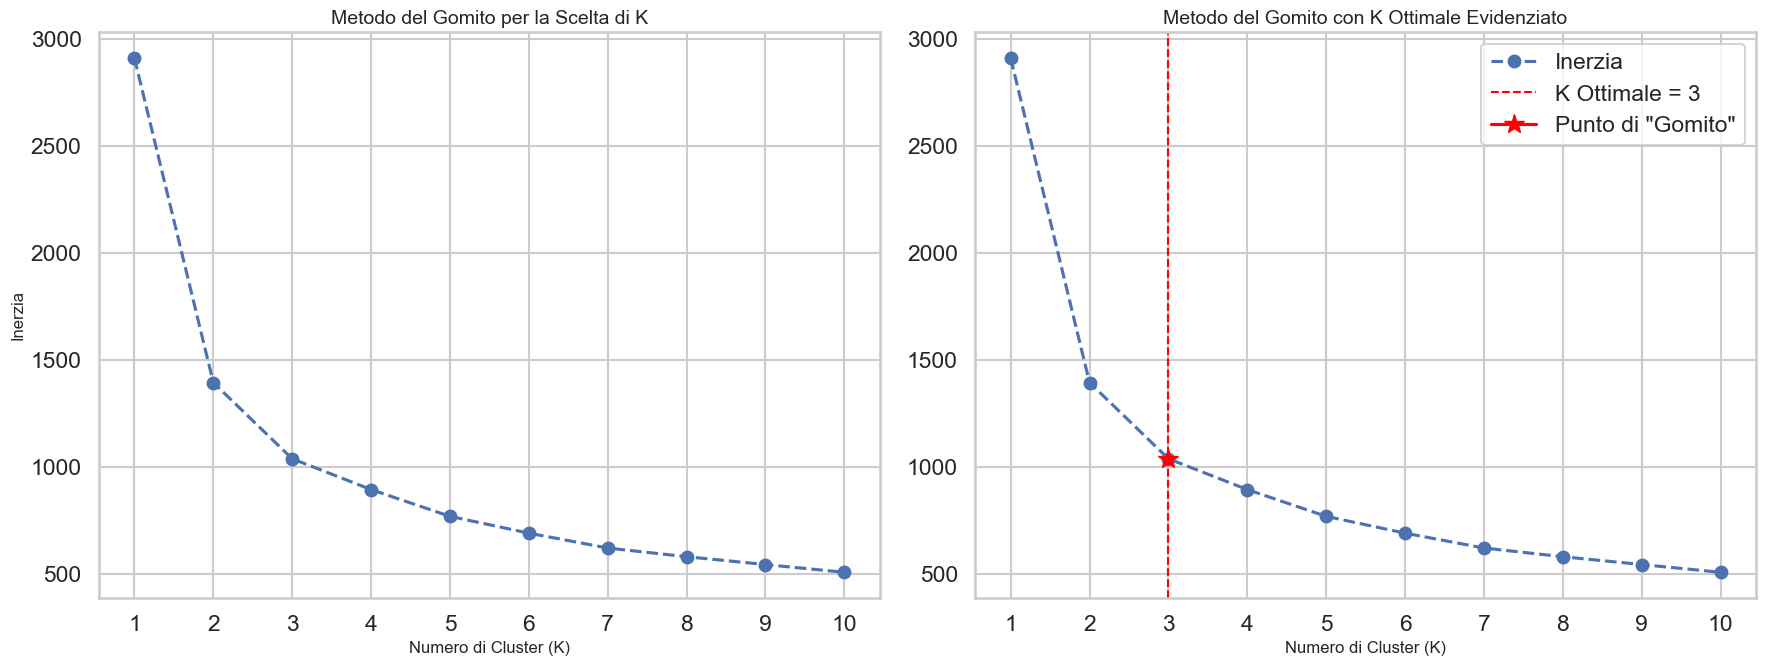

In [445]:
# Crea una figura con due subplot (1 riga, 2 colonne)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Grafico 1: Metodo del Gomito (Sinistra) ---
ax1.plot(K_range, inertia, marker='o', linestyle='--')
ax1.set_title('Metodo del Gomito per la Scelta di K', fontsize=14)
ax1.set_xlabel('Numero di Cluster (K)', fontsize=12)
ax1.set_ylabel('Inerzia', fontsize=12)
ax1.set_xticks(K_range)
ax1.grid(True)

# --- Grafico 2: Metodo del Gomito con K Ottimale (Destra) ---
ax2.plot(K_range, inertia, marker='o', linestyle='--', label='Inerzia')
ax2.set_title('Metodo del Gomito con K Ottimale Evidenziato', fontsize=14)
ax2.set_xlabel('Numero di Cluster (K)', fontsize=12)

K_OTTIMALE = 3

# Evidenzia il K ottimale
ax2.axvline(x=K_OTTIMALE, color='red', linestyle='--', linewidth=1.5, label=f'K Ottimale = {K_OTTIMALE}')

# Aggiunge un marcatore speciale sul punto del gomito
if K_OTTIMALE > 0 and K_OTTIMALE <= len(inertia):
    optimal_inertia_value = inertia[K_OTTIMALE - 1]
    ax2.plot(K_OTTIMALE, optimal_inertia_value, marker='*', markersize=15, color='red', label='Punto di "Gomito"')

ax2.set_xticks(K_range)
ax2.grid(True)
ax2.legend()

# Ottimizza la disposizione dei grafici e li mostra
plt.tight_layout()
plt.show()

### Interpretazione

Il grafico mostra i risultati dell'applicazione del metodo del gomito (Elbow Method) per determinare il numero ottimale di cluster (K) utilizzando K-Means. Come previsto, l'inerzia diminuisce all'aumentare del numero di cluster. Si osserva una forte diminuzione dell'inerzia da K=1 a K=2, una successiva ma ancora significativa, diminuzione da K=2 a K=3 e dopo K=3, la curva si appiattisce visibilmente. Ció ci porta a scegliere K=3 rappresentando i Dati in 3 Gruppi distinti.

Lunghezza di df_cluster_data prima dell'assegnazione cluster: 416
Lunghezza di X_scaled prima dell'assegnazione cluster: 416

Famiglie classificate in 3 cluster.
Macro Gruppo Spesa                             Regione  Anno  \
0                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
1                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
2                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
3                   'Valle d"'Aosta / Vallée d"'Aoste'  2018   
4                   'Valle d"'Aosta / Vallée d"'Aoste'  2019   

Macro Gruppo Spesa  Numero Componenti Famiglia  BEVER  CLOT_FOOTW    FOOD  \
0                                          1.0  47.38       76.10  377.76   
1                                          2.0  52.08      132.98  545.89   
2                                          3.0  61.92      328.53  614.78   
3                                          4.0  81.67      227.78  756.17   
4                                          1.0  30.97       70.58  3

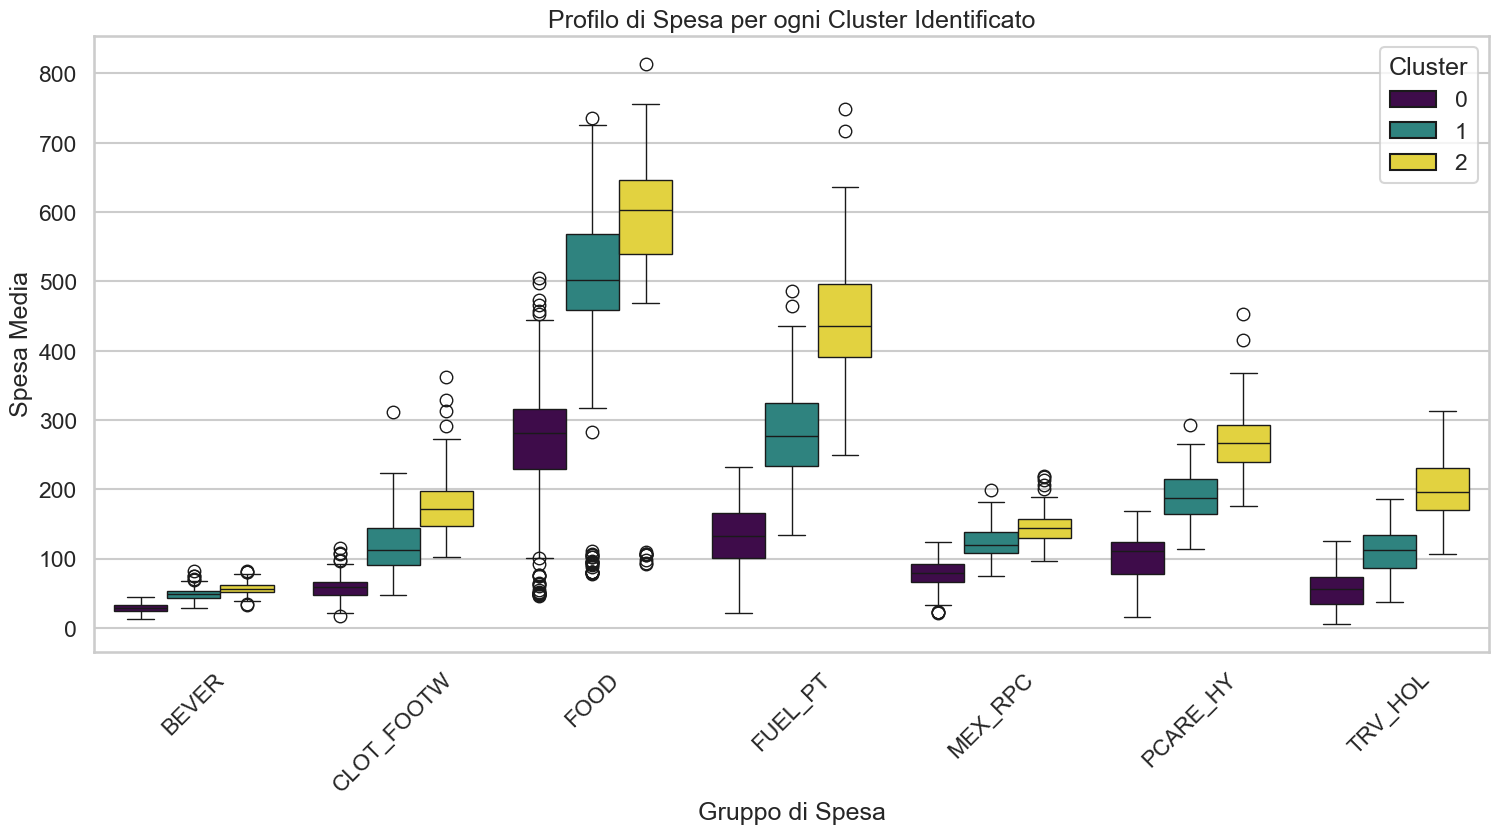

In [446]:
print(f"Lunghezza di df_cluster_data prima dell'assegnazione cluster: {len(df_cluster_data)}")
print(f"Lunghezza di X_scaled prima dell'assegnazione cluster: {len(X_scaled)}")

kmeans = KMeans(n_clusters=K_OTTIMALE, random_state=42, n_init=10)

df_cluster_data['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nFamiglie classificate in {K_OTTIMALE} cluster.")
print(df_cluster_data.head())

cluster_summary = df_cluster_data.groupby('Cluster')[features].mean().round(2)
print("\nCaratteristiche medie di ogni cluster (Spesa in €):")
print(cluster_summary)

plt.figure(figsize=(18, 8))
df_plot_long = pd.melt(df_cluster_data,
                       id_vars=['Cluster'],
                       value_vars=features,
                       var_name='Gruppo di Spesa',
                       value_name='Spesa Media')
sns.boxplot(data=df_plot_long, x='Gruppo di Spesa', y='Spesa Media', hue='Cluster', palette='viridis')
plt.title('Profilo di Spesa per ogni Cluster Identificato', fontsize=18)
plt.xticks(rotation=45)
plt.show()

### Analisi del Profilo di Spesa per ogni Cluster

I box plot per i tre cluster sono ben separati. Questo significa che il nostro modello di clustering ha fatto un buon lavoro nel creare gruppi distinti e omogenei al loro interno, in modo da non creare sovrapposizione tra i profili di spesa dei tre cluster.
*  Per ogni categoria di spesa, ovvero ogni gruppo sull'asse X, si osserva una crescita quasi perfetta passando dal cluster 0 (viola) al cluster 1 (verde) e infine al cluster 2 (giallo)
*  La dimensione dei "box" (l'intervallo interquartile) ci dice quanto è variabile la spesa all'interno di un cluster. Ad esempio, per il FOOD, il box del Cluster 2 (giallo) è abbastanza alto, indicando che c'è una notevole variabilità su quanto si spende per l'alimentazione.
*  Ci sono alcuni outlier, specialmente per la categoria FOOD. Questi rappresentano casi specifici di (Regione, Anno, N. Componenti) che, pur appartenendo a un cluster, hanno una spesa per il cibo insolitamente alta o bassa rispetto al resto del loro gruppo.


Confronto tra Classificazione K-Means e Numero di Componenti:
Cluster                       0   1   2
Numero Componenti Famiglia             
1.0                         101   3   0
2.0                          22  72  10
3.0                           6  64  34
4.0                           4  37  63


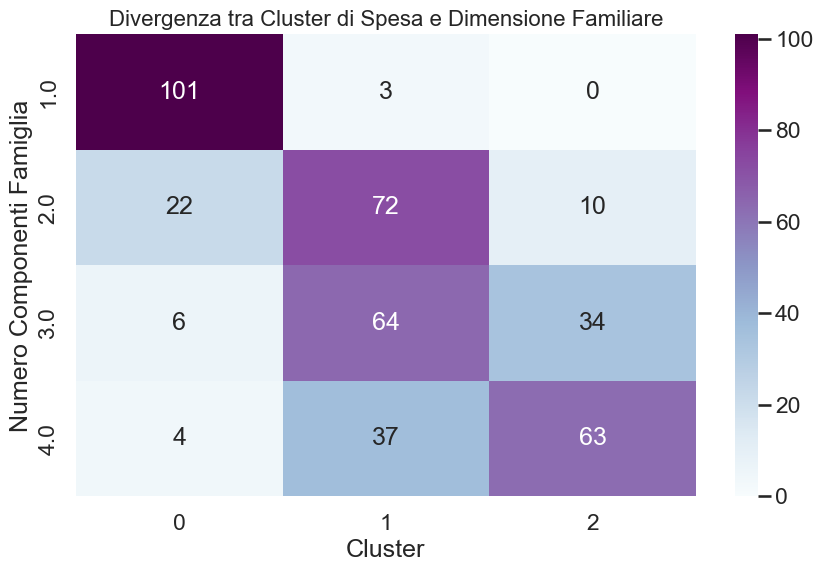

In [447]:
# Creiamo una crosstab per confrontare i cluster con la dimensione della famiglia
crosstab_result = pd.crosstab(df_cluster_data['Numero Componenti Famiglia'], df_cluster_data['Cluster'])

print("\nConfronto tra Classificazione K-Means e Numero di Componenti:")
print(crosstab_result)

plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_result, annot=True, fmt='d', cmap='BuPu')
plt.title('Divergenza tra Cluster di Spesa e Dimensione Familiare', fontsize=16)
plt.show()

### Analisi

Ogni cella mostra quante "tipologie di famiglia" ricadono in quella specifica intersezione.

#### 1. Conferma della Correlazione

Come previsto, c'è una forte correlazione tra le due classificazioni. Questo è visibile dalla diagonale principale (da in alto a sinistra a in basso a destra), dove si concentrano i valori più alti (i colori più scuri):

*   101 famiglie monocomponente (riga 1.0) ricadono nel cluster Bassa Spesa (colonna 0).
*   72 famiglie di due componenti e 64 di tre componenti ricadono nel cluster Media Spesa (colonna 1).
*   63 famiglie di quattro componenti ricadono nel cluster Alta Spesa (colonna 2).

In generale, è vero che le famiglie più piccole tendono a spendere meno e le famiglie più grandi tendono a spendere di più. Se la classificazione fosse perfetta e non ci fossero divergenze, tutti i numeri si troverebbero solo su questa diagonale.

#### 2. Valori Fuori dalla Diagonale

La parte più interessante sono i numeri che si trovano fuori dalla diagonale, che rappresentano i casi in cui la nostra classificazione per spesa *diverge da quella per numero di componenti.

*   Ci sono 22 "tipologie" di famiglie di due componenti che ricadono nel cluster Bassa Spesa. Queste sono coppie che, pur essendo in due, hanno un profilo di spesa molto contenuto, simile a quello dei single.
*   Ci sono 10 "tipologie" di famiglie di due componenti che ricadono nel cluster Alta Spesa. Sono coppie con un tenore di vita e un profilo di spesa paragonabile a quello di famiglie di 4 o più persone. Probabilmente coppie ad alto reddito, che vivono in città costose o con uno stile di vita dispendioso.
*   Ci sono 37 "tipologie" di famiglie di quattro componenti che ricadono nel cluster Media Spesa, spendendo quindi come una famiglia media di 2 o 3 persone.
*   Ci sono 4 "tipologie" di famiglie di quattro componenti che finiscono addirittura nel cluster Bassa Spesa, mostrando un controllo dei costi molto elevato.

#### 3. Risposta alla Domanda della Fase 2

> Il risultato ottenuto diverge dal numero di componenti ‘NUMBER_HOUSEHOLD_COMP)?

Il risultato diverge per alcune famiglie, ma combacia per altre. In generale è normale che le famiglie più numerose abbiano delle spese maggiori, ma questo non è sempre detto, altrimenti troveremmo tutti i dati solo nella diagonale.

Quindi, grazie al clustering K-Means, che segmenta le famiglie in base al loro profilo di spesa, abbiamo dimostrato che:
*   Non tutte le famiglie piccole spendono poco.
*   Non tutte le famiglie grandi spendono molto.

# Fase 3
*Il secondo obiettivo è prevendere le abitudini di acquisto per gruppo di spesa e territorio. Effettua tutte le trasformazioni ai dati che servono.*


In [448]:
# Definiamo l'abitudine di spesa specifica di cui vogliamo prevedere la percentuale
target_abitudine_spesa_regression = "Un anno fa li compravo e ho limitato la spesa in quantità e/o qualità"
df_reg = df_finale[df_finale['Abitudine Spesa'] == target_abitudine_spesa_regression].copy()
df_cluster_data_flat = df_cluster_data.reset_index().copy()

def get_num_componenti_key(val):
    s_val = str(val)
    if 'e più' in s_val:
        return '5e_piu'
    elif '_GE' in s_val:
        return '5e_piu'
    else:
        return s_val.strip().replace('N', '')


df_reg['Numero_Componenti_Key'] = df_reg['Numero Componenti Famiglia'].apply(get_num_componenti_key)
df_cluster_data_flat['Numero_Componenti_Key'] = df_cluster_data_flat['Numero Componenti Famiglia'].apply(
    get_num_componenti_key)
df_reg['Regione'] = df_reg['Regione'].astype(str).str.strip()
df_cluster_data_flat['Regione'] = df_cluster_data_flat['Regione'].astype(str).str.strip()
df_reg['Anno'] = df_reg['Anno'].astype(int)
df_cluster_data_flat['Anno'] = df_cluster_data_flat['Anno'].astype(int)

df_reg = pd.merge(
    df_reg,
    df_cluster_data_flat[['Regione', 'Anno', 'Numero_Componenti_Key', 'Cluster']],
    on=['Regione', 'Anno', 'Numero_Componenti_Key'],
    how='left'
)

df_reg.dropna(subset=['Cluster'], inplace=True)
df_reg['Cluster'] = df_reg['Cluster'].astype(int).astype(str)

print("Dataset di regressione pronto (prime 5 righe):")
print(df_reg.head())
print("\nInformazioni sul Dataset di Regressione:")
print(df_reg.info())

y_reg = df_reg['Percentuale Famiglie']

features_to_use_reg = [
    'Anno',
    'Regione',
    'Macro Gruppo Spesa',
    'Numero_Componenti_Key',
    'Micro Spesa Media',
    'Cluster'
]

X_reg = df_reg[features_to_use_reg]

numerical_features_reg = ['Anno', 'Micro Spesa Media']
categorical_features_reg = ['Regione', 'Macro Gruppo Spesa', 'Numero_Componenti_Key', 'Cluster']

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
    ])

print("\nTrasformazioni definite per le features:")
print(f"Features Numeriche: {numerical_features_reg}")
print(f"Features Categoriche: {categorical_features_reg}")

print("\nPreparazione dati per Fase 3 completata.")

Dataset di regressione pronto (prime 5 righe):
  Macro Regione Regione  Anno Macro Gruppo Spesa  \
0        Italia  Italia  2018               FOOD   
1        Italia  Italia  2018               FOOD   
2        Italia  Italia  2018               FOOD   
3        Italia  Italia  2018               FOOD   
5        Italia  Italia  2018               FOOD   

                             Micro Gruppo Spesa  \
0  -- prodotti alimentari e bevande analcoliche   
1  -- prodotti alimentari e bevande analcoliche   
2  -- prodotti alimentari e bevande analcoliche   
3  -- prodotti alimentari e bevande analcoliche   
5                           Prodotti alimentari   

                                     Abitudine Spesa  Percentuale Famiglie  \
0  Un anno fa li compravo e ho limitato la spesa ...                  31.4   
1  Un anno fa li compravo e ho limitato la spesa ...                  31.4   
2  Un anno fa li compravo e ho limitato la spesa ...                  31.4   
3  Un anno fa li comp

# **Fase 4:** Prevedere la Percentuale di Famiglie che Limita la Spesa
*Applica ora KNNregressor, l’Agglomerative Clustering e il DecisionTreeRegressor, il risultato cambia? Quali sono le principali differenze?*

--- KNN Regressor ---
MAE: 2.382
MSE: 17.883
RMSE: 4.229
R2: 0.832


--- Decision Tree ---
MAE: 4.5
MSE: 36.05
RMSE: 6.004
R2: 0.662




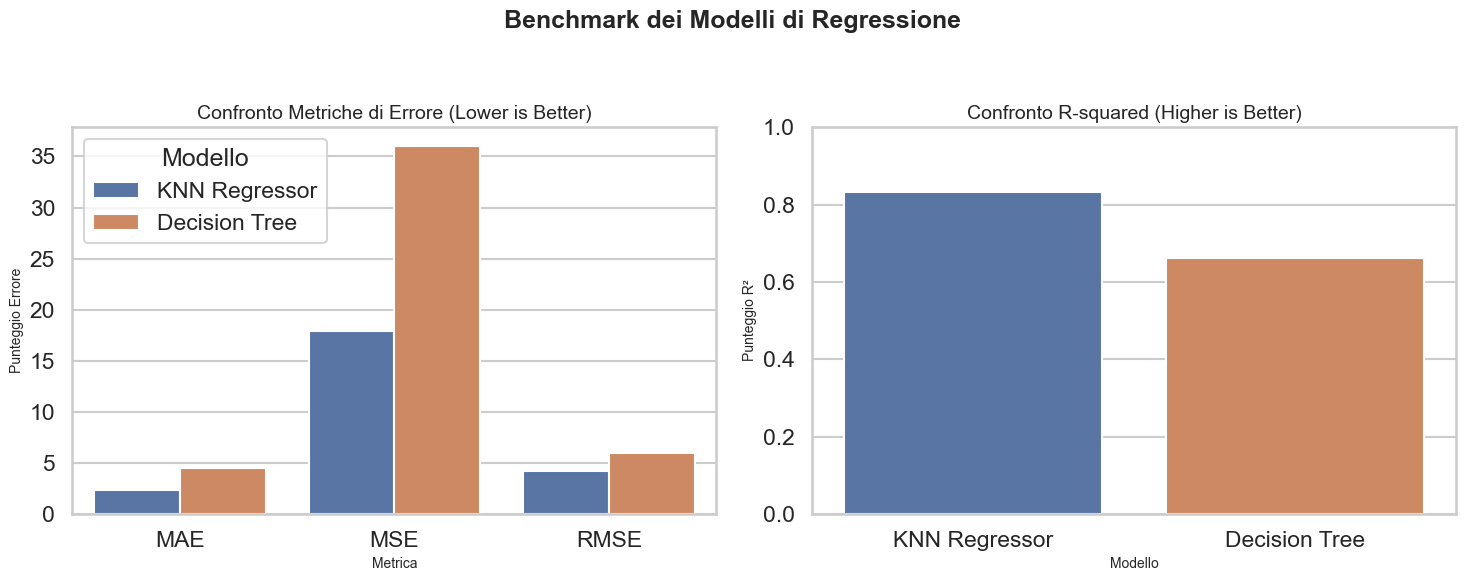

In [449]:
# 1. Divisione del dataset in set di training e test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

if X_test_reg.empty or y_test_reg.shape[0] == 0:
    print("I set di test per la regressione sono vuoti. Impossibile calcolare metriche.")
else:
    # 2. Applicazione del Preprocessor
    X_train_processed_reg = preprocessor_reg.fit_transform(X_train_reg)
    X_test_processed_reg = preprocessor_reg.transform(X_test_reg)

    X_train_processed_reg_dense = X_train_processed_reg.toarray()
    X_test_processed_reg_dense = X_test_processed_reg.toarray()

    # --- K-Nearest Neighbors (KNN) Regressor ---
    knn_regressor = KNeighborsRegressor(n_neighbors=5)
    knn_regressor.fit(X_train_processed_reg_dense, y_train_reg)
    y_pred_knn_reg = knn_regressor.predict(X_test_processed_reg_dense)

    # --- Decision Tree Regressor ---
    dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=5)
    dt_regressor.fit(X_train_processed_reg_dense, y_train_reg)
    y_pred_dt_reg = dt_regressor.predict(X_test_processed_reg_dense)

    # 3. Calcolo delle metriche di valutazione
    models_metrics = {
        'KNN Regressor': {
            'MAE': mean_absolute_error(y_test_reg, y_pred_knn_reg),
            'MSE': mean_squared_error(y_test_reg, y_pred_knn_reg),
            'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_knn_reg)),
            'R2': r2_score(y_test_reg, y_pred_knn_reg)
        },
        'Decision Tree': {
            'MAE': mean_absolute_error(y_test_reg, y_pred_dt_reg),
            'MSE': mean_squared_error(y_test_reg, y_pred_dt_reg),
            'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_dt_reg)),
            'R2': r2_score(y_test_reg, y_pred_dt_reg)
        }
    }

    # Stampa delle metriche
    for model_name, metrics in models_metrics.items():
        print(f"--- {model_name} ---")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {round(value, 3)}")
        print("\n")

    # 4. Creazione dei Grafici di Benchmark
    df_metrics = pd.DataFrame(models_metrics).T.reset_index().rename(columns={'index': 'Model'})

    # Prepariamo i dati per i grafici
    df_error_metrics = df_metrics.melt(id_vars='Model', value_vars=['MAE', 'MSE', 'RMSE'], var_name='Metric',
                                       value_name='Score')
    df_r2_metric = df_metrics[['Model', 'R2']]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Benchmark dei Modelli di Regressione', fontsize=18, weight='bold')

    # Grafico per le metriche di errore (MAE, MSE, RMSE)
    sns.barplot(data=df_error_metrics, x='Metric', y='Score', hue='Model', ax=axes[0])
    axes[0].set_title('Confronto Metriche di Errore (Lower is Better)', fontsize=14)
    axes[0].set_ylabel('Punteggio Errore', fontsize=10)
    axes[0].set_xlabel('Metrica', fontsize=10)
    axes[0].legend(title='Modello')

    # Grafico per R-squared
    sns.barplot(data=df_r2_metric, x='Model', y='R2', hue='Model', ax=axes[1], dodge=False)
    axes[1].set_title('Confronto R-squared (Higher is Better)', fontsize=14)
    axes[1].set_ylabel('Punteggio R²', fontsize=10)
    axes[1].set_xlabel('Modello', fontsize=10)
    axes[1].set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Risposta alla Domanda: "Il risultato cambia? Quali sono le principali differenze?"

Sì, il risultato è diverso perché i tre modelli applicati rispondono a domande di business differenti e operano in modi distinti.
KNN Regressor e Decision Tree Regressor sono modelli di regressione supervisionata usati per prevedere un valore, mentre Agglomerative Clustering è un modello di clustering non supervisionato usato per scoprire pattern nascosti nei dati.


#### 1. Confronto tra KNN Regressor e Decision Tree Regressor (Modelli di Previsione)

Entrambi i modelli sono stati addestrati per prevedere la Percentuale Famiglie che adotta una certa abitudine, ma hanno approcci e performance diverse.

##### Analisi Quantitativa:

*   Metriche di Errore (MAE, MSE, RMSE - Lower is Better):
    *   KNN Regressor: Ha un MAE di 2.38, un MSE di 17.88 e un RMSE di 4.23.
    *   Decision Tree: Ha un MAE di 4.5, un MSE di 36.05 e un RMSE di 6.00.
    *   Conclusione: Il KNN Regressor è migliore in termini di accuratezza. Il suo errore medio (MAE) è quasi la metà di quello del Decision Tree (2.38% contro 4.5%). Questo significa che, in media, le previsioni del KNN si discostano dal valore reale di soli 2.38 punti percentuali, rendendolo un modello predittivo più affidabile. Il grafico a barre "Confronto Metriche di Errore" fa vedere proprio questa superiorità.


*   Metrica del Fit (R-squared - Higher is Better):
    *   KNN Regressor: Ha un R² di 0.832. Questo è un buon risultato e significa che il modello è in grado di spiegare circa l'83% della variabilità della variabile target.
    *   Decision Tree: Ha un R² di 0.662. Questo è un valore discreto ma molto inferiore rispetto al KNN Regressor, indicando che spiega solo il 66% della variabilità.
    *   Conclusione: Anche l'R-squared conferma la superiorità del KNN. Il grafico "Confronto R-squared" mostra proprio questo.

In [389]:
# --- Agglomerative Clustering ---
agg_clustering_reg = AgglomerativeClustering(n_clusters=K_OTTIMALE)
agg_labels_reg = agg_clustering_reg.fit_predict(X_train_processed_reg_dense)
print(f"\nAgglomerative Clustering ha identificato {len(np.unique(agg_labels_reg))} cluster nel training set.")

df_agg_clusters_reg = pd.DataFrame(X_train_processed_reg_dense, columns=preprocessor_reg.get_feature_names_out())
df_agg_clusters_reg['Target_Value'] = y_train_reg.reset_index(drop=True)
df_agg_clusters_reg['Agg_Cluster'] = agg_labels_reg

# Calcolo dei valori medi per il grafico
agg_cluster_means = df_agg_clusters_reg.groupby('Agg_Cluster')['Target_Value'].mean().round(2).reset_index()
print("\nValori medi di 'Percentuale Famiglie' all'interno di ogni cluster Agglomerative:")
print(agg_cluster_means)

print("\n--- FINE FASE 4 ---")


Agglomerative Clustering ha identificato 3 cluster nel training set.

Valori medi di 'Percentuale Famiglie' all'interno di ogni cluster Agglomerative:
   Agg_Cluster  Target_Value
0            0         28.06
1            1         25.32
2            2         29.60

--- FINE FASE 4 ---


#### 2. Agglomerative Clustering

Questo modello è diverso dai due precedenti: non fa previsioni e non usa la variabile Percentuale Famiglie per addestrarsi. Il suo scopo è raggruppare i dati in cluster omogenei.
*   I valori medi della variabile target (Percentuale Famiglie) all'interno dei cluster sono:
    *   Cluster 0: 28.06
    *   Cluster 1: 25.32
    *   Cluster 2: 29.60


A differenza dei regressori, l'output del clustering non è una previsione numerica, ma un'etichetta di gruppo. Il suo valore non sta nell'accuratezza predittiva, ma nella capacità di scoprire e descrivere segmenti di mercato o profili di comportamento che non erano evidenti a prima vista.

## Conclusione

I risultati dei tre modelli si completano a vicenda. Il KNN Regressor si è dimostrato lo strumento migliore per una previsione accurata, ma non é spiegabile in termini di regole di business, in quanto la sua è una previsione "black box", basata sulla media di casi simili. Il Decision Tree, pur essendo meno preciso, permette di capire il motivo delle scelte del modello (ripercorrendo l'albero). Infine, l'Agglomerative Clustering ha fornito una visione strategica, segmentando il mercato in profili di comportamento distinti. La scelta del modello da utilizzare dipende quindi strettamente dall'obiettivo di business: prevedere, spiegare o segmentare.